In [1]:
%load_ext autoreload
%autoreload 2


In [18]:
import src.urban_diff_helper as ud_helper
import pandas as pd
from scipy.stats import wilcoxon,ttest_rel,kendalltau, spearmanr
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from src.urban_diff_helper import ADMIN_STR
from collections import defaultdict
from shapely.ops import cascaded_union
from itertools import combinations

In [127]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats


In [17]:
admin_strs = [ADMIN_STR(m,u) for m in [False, True] for u in [False,True]]

In [51]:
n_bins=24

In [58]:
method_order = {
    'ageb<br/>area': 0,
    'ageb<br/>pop': 1,
    'grid<br/>_idw': 2,
    'grid<br/>area': 3,
    'grid<br/>pop': 4,
    'vor<br/>area': 5,
    'vor<br/>pop': 6
}
method_names = list(method_order.keys())


# load geometries

In [6]:
zms, zms_agebs, zms_tvor, zms_grids, zms_sub_vors, mg_mappings = ud_helper.load_geoms()

loading zms
loading agebs
loading voronoi
loading existing mexico tower voronoi file: data/mex_tw_intpl/voronoi.geojson
==================== loading grids False False 2019-12-16 14:27:56.295248
=====computing mpa_grids
reading existing grids
==================== loading grids False True 2019-12-16 14:29:45.664094
loading existing file data/mexico/geography-socioeconomics/2010MetropolitanAreas/grids_500_whole_urb.geojson.gz
==================== loading grids True False 2019-12-16 14:29:50.267944
loading existing file data/mexico/geography-socioeconomics/2010MetropolitanAreas/grids_500_perMun_uNr.geojson.gz
==================== loading grids True True 2019-12-16 14:30:32.039569
loading existing file data/mexico/geography-socioeconomics/2010MetropolitanAreas/grids_500_perMun_urb.geojson.gz
loading existing mexico tower voronoi file: data/mex_tw_intpl/voronoi.geojson
computing the intersection between p1 tower and p2 CVE_SUN
len(p1)=5731 > 10 * len(p2)=59, swap them
computing area of the i

In [52]:

zms_sub_vors = {}
for per_mun in [False, True]:
    for urb_only in [False, True]:
#         print('=' * 20, 'loading grids', per_mun, urb_only, dt.datetime.now())
        zms_sub_vors[(per_mun, urb_only)] = ud_helper.region.mpa_vors(per_mun, urb_only)

loading existing mexico tower voronoi file: data/mex_tw_intpl/voronoi.geojson
computing the intersection between p1 tower and p2 CVE_SUN
len(p1)=5731 > 10 * len(p2)=59, swap them
computing area of the intersections
computing the weight
loading existing mexico tower voronoi file: data/mex_tw_intpl/voronoi.geojson
computing the intersection between p1 tower and p2 CVE_SUN
len(p1)=5731 > 10 * len(p2)=59, swap them
computing area of the intersections
computing the weight
loading existing mexico tower voronoi file: data/mex_tw_intpl/voronoi.geojson
computing the intersection between p1 tower and p2 mun_id
len(p1)=5731 > 10 * len(p2)=367, swap them
computing area of the intersections
computing the weight
loading existing mexico tower voronoi file: data/mex_tw_intpl/voronoi.geojson
computing the intersection between p1 tower and p2 mun_id
len(p1)=5731 > 10 * len(p2)=367, swap them
computing area of the intersections
computing the weight


# load interpolation and interpolate avg

In [7]:
avg_tw, avg_a, avg_g, avg_idw, avg_vor = ud_helper.interpolation(zms_grids,zms_sub_vors,n_bins=24)

loading cached tw average stats/stat_tw_dow_aver_hr_uniq_user-out+in.pickle
to_map_agebs loading existing file data/mex_tw_intpl/tower_to_mpa_agebs_by_area.csv
to_map_agebs loading existing file data/mex_tw_intpl/tower_to_mpa_agebs_by_pop.csv
to_map_grids loading existing file data/mex_tw_intpl/tower_to_mpa_g500_whole_uNr_area.csv
to_map_grids loading existing file data/mex_tw_intpl/tower_to_mpa_g500_whole_urb_area.csv
to_map_grids loading existing file data/mex_tw_intpl/tower_to_mpa_g500_perMun_uNr_area.csv
to_map_grids loading existing file data/mex_tw_intpl/tower_to_mpa_g500_perMun_urb_area.csv
to_map_grids loading existing file data/mex_tw_intpl/tower_to_mpa_g500_whole_uNr_pop.csv
to_map_grids loading existing file data/mex_tw_intpl/tower_to_mpa_g500_whole_urb_pop.csv
to_map_grids loading existing file data/mex_tw_intpl/tower_to_mpa_g500_perMun_uNr_pop.csv
to_map_grids loading existing file data/mex_tw_intpl/tower_to_mpa_g500_perMun_urb_pop.csv
interpolate_idw loading existing file

In [61]:

avg_vor = {}
for by in ['area', 'pop']:
    for per_mun in [False, True]:
        for urb_only in [False, True]:
            sub_vors = zms_sub_vors[(per_mun, urb_only)]
            t2v = ud_helper.tw_int.to_mpa_vors(by=by, per_mun=per_mun, urb_only=urb_only, zms_vors=sub_vors)
            t2v.set_index('vor', inplace=True)
            avg_vor[(by, per_mun, urb_only)] = ud_helper.tw_int.interpolate_stats(avg_tw, t2v)


computing to_map_vors area False False
computing to_map_vors area False True
computing to_map_vors area True False
computing to_map_vors area True True
to_mpa_vors loading existing file data/mex_tw_intpl/tower_to_mpa_vors_whole_uNr_pop.csv
to_mpa_vors loading existing file data/mex_tw_intpl/tower_to_mpa_vors_whole_urb_pop.csv
to_mpa_vors loading existing file data/mex_tw_intpl/tower_to_mpa_vors_perMun_uNr_pop.csv
to_mpa_vors loading existing file data/mex_tw_intpl/tower_to_mpa_vors_perMun_urb_pop.csv


# statistics test

In [8]:
def sig_lvl(x):
    if x==-1 or x==0:
        return '-'
    if x <0.001:
        return '***'
    if x<0.01:
        return '**'
    if x<0.05:
        return '*'
    return ''

In [9]:
def statistics_test(test_func, stat_df, clean_table=False, larger_than=0.0):

    n_cols = stat_df.shape[1]
    p_values = np.zeros((n_cols, n_cols))
    test_measures = np.ones((n_cols, n_cols))
    for i in range(n_cols):
        for j in range(i + 1, n_cols):
            m, p = test_func(stat_df.iloc[:, i], stat_df.iloc[:, j])
            p_values[i, j] = p_values[j, i] = p
            test_measures[i, j] = test_measures[j, i] = m

    
    p_values = pd.DataFrame(p_values,
                          index=stat_df.columns,
                          columns=stat_df.columns)
    test_measures[test_measures<=larger_than] = 0
    test_measures = pd.DataFrame(test_measures,
                          index=stat_df.columns,
                          columns=stat_df.columns)
    
    if clean_table:
        p_values = p_values.applymap(sig_lvl)
#         test_measures = test_measures.applymap(lambda x: f'{x:.3f}')
    return p_values, test_measures

wilcoxon_test = lambda stat_df, clean_table, larger_than: statistics_test(wilcoxon, stat_df, clean_table, larger_than)
paired_t_test = lambda stat_df, clean_table, larger_than: statistics_test(ttest_rel, stat_df, clean_table, larger_than)
ken_tau_corr = lambda stat_df, clean_table, larger_than: statistics_test(kendalltau, stat_df, clean_table, larger_than)
spe_rho_corr = lambda stat_df, clean_table, larger_than: statistics_test(spearmanr, stat_df, clean_table, larger_than)

# draw function

In [10]:
import plotly.offline as offline
offline.init_notebook_mode(connected=True)
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython.core.display import HTML 

In [11]:
def draw_scatter(data_df, mode='lines+markers',height=600,margin_r=100):
    
    data = [
        go.Scatter(x='zm' + data_df.index.astype(str),
                   y=data_df[intpl_type].tolist(),
                   name=str(intpl_type),
                   mode='lines+markers'
                  ) for intpl_type in data_df
    ]
    fig = go.Figure()
    for trace in data:
        fig.add_trace(trace)
    fig.update_layout(height=height,margin=dict(l=10, r=margin_r, t=10, b=10),)

    offline.iplot(fig)

In [12]:
swap = lambda df, i, j: df.swaplevel(i,j).T.swaplevel(i,j).sort_index(level=range(len(df.columns.levels))).T.sort_index(level=range(len(df.columns.levels)))

In [13]:

def background_gradient(s, m=None, M=None,  cmap='Oranges', low=0, high=0.2):

    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]


def grad_bg(df, cmap='Oranges', mini=None, maxi=None, high=0, mask_tril=False,format_float=True):
    if mini is None:
        mini = df.min().min()
    if maxi is None:
        maxi = df.max().max()
    if mask_tril:
        df = df.mask(np.tril(np.ones(df.shape, dtype=np.bool_),-1))
    format_str = "{:.3f}" if format_float else "{:.0f}"
    style= df.style.apply(background_gradient, m=mini, M=maxi, cmap=cmap, high=high).format(format_str).set_table_attributes("style='display:inline'")
    return HTML(style.render().replace('nan',''))

In [14]:
def grad_bg(df, cmap='Oranges', mini=None, maxi=None, high=0, mask_tril=False,format_float=True):
    if mini is None:
        mini = df.min().min()
    if maxi is None:
        maxi = df.max().max()
    if mask_tril:
        df = df.mask(np.tril(np.ones(df.shape, dtype=np.bool_),-1))
    format_str = "{:.3f}" if format_float else "{:.0f}"
    style= df.style.apply(background_gradient, m=mini, M=maxi, cmap=cmap, high=high).format(format_str).set_table_attributes("style='display:inline'")
    return HTML(style.render().replace('nan',''))

In [135]:
def grad_bg_with_str(df, mini, maxi, cmap='Oranges', high=0, mask_tril=False):
    
    def bg_color(arr, low=0, high=0.2):
#         print(arr)
        values = arr.apply(lambda x: float(x.split(' ')[0]) if type(x)==str else x).values
        rng = maxi - mini
        norm = colors.Normalize(mini - (rng * low),
                                maxi + (rng * high))
        normed = norm(values)
        c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
        return ['background-color: %s' % color for color in c]
    
    if mask_tril:
        df = df.mask(np.tril(np.ones(df.shape, dtype=np.bool_),-1))
    style= df.style.apply(bg_color, high=high)
    return HTML(style.render().replace('nan',''))

# urban dilatation index

In [20]:
# compute
print('computing dv_a')
dv_a = {}
for by, avg in avg_a.items():
    dv_a[by] = ud_helper.dilatation.dv_for_mpa_ageb(avg, zms, zms_agebs)

print('computing dv_g')
dv_g = {}
for (side, by, per_mun), avg in avg_g.items():
    zms_g = zms_grids[(side, per_mun)]
    dv_g[(side, by, per_mun)] = ud_helper.dilatation.dv_for_mpa_grids(avg, zms, zms_g)

print('computing dv_idw')
dv_idw = {}
for key, avg in avg_idw.items():
    zms_g = zms_grids[key]
    dv_idw[key] = ud_helper.dilatation.dv_for_mpa_grids(avg, zms, zms_g)

computing dv_a
computing dv_g
computing dv_idw


In [437]:
# flatten the dictionary of stats
var = 'dilatation coefficient'
a = {('ageb', 'area'):dv_a['area'][var], ('ageb', 'pop') : dv_a['pop'][var]}
g= {(f'g{side//1000}', by, ):dv[var] for (side, by, per_mun), dv in dv_g.items() if not per_mun}
idw= {(f'g{side//1000}','_idw') :dv[var] for (side, per_mun), dv in dv_idw.items() if not per_mun}
dila_coef = pd.DataFrame({**a, **g, **idw})

In [278]:
# Visualization
sort_col = ud_helper.zms_sort_cols[0]
dila_coef = dila_coef.loc[zms.sort_values(sort_col).index]

# sort_col = dila_coef.columns[0]
# dila_coef=dila_coef.sort_values(sort_col)
# print(sort_col)

draw_scatter(dila_coef, height=300)
draw_scatter(dila_coef.std(axis=1).to_frame(), height=300, margin_r=135)

In [460]:
64*59

3776

In [456]:
# even though (ageb, pop) and (g1 pop) has similar values, 
# but the std could also be small.
dila_wil_ps, _ = wilcoxon_test(dila_coef, clean_table=False)
grad_bg(dila_wil_ps, cmap='PuBu',high=.2)
# dila_wil_ps

In [470]:
dila_ken_ps, dila_ken_tau = ken_tau_corr(
    dila_coef, clean_table=False, larger_than=0.8)
print()
grad_bg(dila_ken_ps, cmap='PuBu',high=.2)

In [471]:
grad_bg(swap(dila_ken_tau,0,1))

In [472]:
grad_bg(swap(swap(dila_ken_tau,0,1),0,1))

# hotspots

In [16]:
loading = ('ageb', 'grid', 'idw', 'vor')
hs_stats_ageb, hs_stats_g, hs_stats_idw, hs_stats_vor, hs_stats_tw = ud_helper.compute_hotspot_stats(
    avg_a, avg_g, avg_idw, avg_tw, avg_vor,
    zms, zms_agebs, zms_grids,zms_sub_vors,mg_mappings,
    hs_type='loubar',loading=loading)

('area', False, False) working on 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
('area', False, True) working on 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
('area', True, False) working on 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
('area', True, True) working on 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
('pop', False, False) working on 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 

## inter metro measurements correlation Kendall, spearmanr

In [222]:
def inter_metro_measurement(zms, hs_stats, geom_type, measure_type, time_range=None,measure_name=None,idw=False):
    measures = {}
    if type(hs_stats) is dict:
        for key, stats in hs_stats.items():
            if not idw:
                by, per_mun, urb_only = key
            else:
                by = '_idw10'
                per_mun, urb_only = key
                
            if time_range is None: 
                # for number of average hotspot
                measures[(ADMIN_STR(per_mun, urb_only), geom_type, by)] = [
                    stats[measure_type][sun]['average'] for sun in zms.index
                ]                
            else:
                # for compactness
                measures[(ADMIN_STR(per_mun, urb_only), geom_type, by)] = [
                    stats[measure_type][sun][time_range][measure_name] for sun in zms.index
                ]
                
    elif type(hs_stats) is list:
        assert len(hs_stats) == len(geom_type) == len(idw)
        for hstat, gtype, is_idw in zip(hs_stats, geom_type, idw):
            measures.update(inter_metro_measurement(zms, hstat, gtype, measure_type, time_range, measure_name, is_idw))
    return measures

In [223]:
hs_stats = [hs_stats_ageb, hs_stats_g, hs_stats_idw, hs_stats_vor]
geom_types = ['ageb', 'g.5km', 'g.5km', 'vor']
idws = [False, False, True,False]
compactness_indexes = {}
for measure_name in ['comp_coef', 'cohesion', 'proximity','NMI','NMMI']:
    for time_range in ['all_day', 'home_time', 'work_time']:
        compact = inter_metro_measurement(zms, hs_stats, geom_types, 'compactness', time_range, measure_name, idws)
        compact =  pd.DataFrame(compact,index=zms.index)
        compactness_indexes[(measure_name, time_range)] = compact

comp_ken_tau= []
comp_spr_rho = []
for (measure_name, time_range), compact in compactness_indexes.items():
    key_str = (measure_name + '<br>' + time_range).replace('_',' ')
    p_values, taus = ken_tau_corr(compact, clean_table=False,larger_than=.0)
    comp_ken_tau.append((key_str, taus))
    p_values, rhos = spe_rho_corr(compact, clean_table=False,larger_than=.0)
    comp_spr_rho.append((key_str, rhos))

In [224]:
hs_stats = [hs_stats_ageb, hs_stats_g, hs_stats_idw, hs_stats_vor]
geom_types = ['ageb', 'g.5km', 'g.5km', 'vor']
idws = [False, False, True,False]
average_number_hotspot = pd.DataFrame(inter_metro_measurement(zms, hs_stats, geom_types, 'n_hs', idw=idws),index=zms.index)

nhs_spr_ps, nhs_spr_rho = spe_rho_corr(average_number_hotspot, clean_table=False,larger_than=0.0)
nhs_ken_ps, nhs_ken_tau = ken_tau_corr(average_number_hotspot, clean_table=False,larger_than=0.0)


### table and plots of the correlations

#### compactness

In [170]:
comp_ken_ps, comp_ken_tau = ken_tau_corr(comp_coef, clean_table=False,larger_than=.0)
comp_spr_ps, comp_spr_rho = spe_rho_corr(comp_coef, clean_table=False, larger_than=.0)

In [219]:
comp_work_ken_ps, comp_work_ken_tau = ken_tau_corr(comp_coef_work, clean_table=False,larger_than=.0)
comp_work_spr_ps, comp_work_spr_rho = spe_rho_corr(comp_coef_work, clean_table=False, larger_than=.0)

In [220]:
comp_home_ken_ps, comp_home_ken_tau = ken_tau_corr(comp_coef_home, clean_table=False,larger_than=.0)
comp_home_spr_ps, comp_home_spr_rho = spe_rho_corr(comp_coef_home, clean_table=False, larger_than=.0)

In [40]:

swap_df = comp_ken_tau

display(grad_bg(swap_df.T.sort_index(level=0).T.sort_index(level=0), mask_tril=True))

# swap_df = swap(swap_df, 0,2)
# # display(grad_bg(swap_df))
# swap_df = swap(swap_df, 1,2)
# display(grad_bg(swap_df))

/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning:

invalid value encountered in less



In [236]:


sort_col = ud_helper.zms_sort_cols[3]
comp_coef = comp_coef.loc[zms.sort_values(sort_col).index]
sort_col = comp_coef.columns[0]
comp_coef=comp_coef.sort_values(sort_col)
print(sort_col)

draw_scatter(comp_coef, height=300)
draw_scatter(comp_coef.std(axis=1).to_frame(), height=300, margin_r=175)

('whole_uNr', 'ageb', 'area')


#### for N hotspot

In [379]:
# display(grad_bg(nhs_ken_tau.T.sort_index(level=0).T.sort_index(level=0),mini=0))

# swap_df = swap(nhs_ken_tau, 0,2)
# display(grad_bg(swap_df))

# swap_df = swap(swap_df, 1,2)
# display(grad_bg(swap_df))
# swap_df = swap(swap_df, 2,0)
# display(grad_bg(swap_df))

In [288]:

sort_col = Mean_number_hot.columns[0]
Mean_number_hot=Mean_number_hot.sort_values(sort_col)
print(sort_col)

draw_scatter(Mean_number_hot)

('ageb', nan, 'area', 'zm')


### display table

#### method-level pairwise corr
4 big table(Admin-bound); small table: per index, corr between methods

In [608]:
admin_strs = [ADMIN_STR(m,u) for m in [False, True] for u in [False,True]]

In [1317]:
def print_table(astr, measurements, add_mean=False):
    print(astr.replace('_','\n'))
    for index_name, index_corr in measurements:
        tbl = index_corr.T.sort_index(level=0).T.sort_index(level=0).loc[astr, astr].copy()
        tbl.columns =['<br/>'.join(col).strip() for col in tbl.columns.values]
        tbl.index =['<br/>'.join(col).strip() for col in tbl.index.values]
        tbl.index.name=index_name
        if add_mean:
            tbl['row<br/>mean'] = (tbl.sum(axis=0)-1)/(tbl.shape[1]-1)
            
        dis_tbl = grad_bg(tbl, mask_tril=True, mini=0)
        display(dis_tbl)

In [1313]:
grad_bg(tmp_mat, mask_tril=True, mini=0)

In [616]:
# kendal Tau
i=3
astr=admin_strs[i]
measurements = [('Avg N HS', nhs_ken_tau)]+comp_ken_tau
print_table(astr, measurements)

PerMun
Urban


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
Avg N HS,,,,,,,
agebarea,1.000,0.780,0.586,0.648,0.727,0.763,0.708
agebpop,,1.000,0.525,0.604,0.704,0.744,0.712
g.5km_idw10,,,1.000,0.676,0.698,0.600,0.567
g.5kmarea,,,,1.000,0.801,0.587,0.545
g.5kmpop,,,,,1.000,0.672,0.639
vorarea,,,,,,1.000,0.904
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
comp coefall day,,,,,,,
agebarea,1.000,0.619,0.607,0.755,0.576,0.598,0.536
agebpop,,1.000,0.640,0.640,0.735,0.457,0.580
g.5km_idw10,,,1.000,0.736,0.693,0.591,0.529
g.5kmarea,,,,1.000,0.721,0.645,0.569
g.5kmpop,,,,,1.000,0.529,0.694
vorarea,,,,,,1.000,0.632
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
comp coefhome time,,,,,,,
agebarea,1.000,0.628,0.610,0.756,0.576,0.597,0.518
agebpop,,1.000,0.642,0.650,0.756,0.484,0.584
g.5km_idw10,,,1.000,0.744,0.702,0.604,0.544
g.5kmarea,,,,1.000,0.729,0.654,0.573
g.5kmpop,,,,,1.000,0.525,0.681
vorarea,,,,,,1.000,0.639
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
comp coefwork time,,,,,,,
agebarea,1.000,0.633,0.617,0.744,0.594,0.595,0.496
agebpop,,1.000,0.689,0.662,0.805,0.450,0.653
g.5km_idw10,,,1.000,0.742,0.756,0.562,0.622
g.5kmarea,,,,1.000,0.738,0.608,0.539
g.5kmpop,,,,,1.000,0.493,0.677
vorarea,,,,,,1.000,0.581
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
cohesionall day,,,,,,,
agebarea,1.000,0.513,0.336,0.570,0.357,0.527,0.397
agebpop,,1.000,0.534,0.494,0.721,0.404,0.548
g.5km_idw10,,,1.000,0.507,0.600,0.379,0.411
g.5kmarea,,,,1.000,0.584,0.578,0.479
g.5kmpop,,,,,1.000,0.410,0.610
vorarea,,,,,,1.000,0.531
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
cohesionhome time,,,,,,,
agebarea,1.000,0.509,0.330,0.555,0.350,0.590,0.395
agebpop,,1.000,0.531,0.470,0.724,0.468,0.568
g.5km_idw10,,,1.000,0.486,0.578,0.390,0.393
g.5kmarea,,,,1.000,0.545,0.579,0.426
g.5kmpop,,,,,1.000,0.445,0.614
vorarea,,,,,,1.000,0.620
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
cohesionwork time,,,,,,,
agebarea,1.000,0.518,0.345,0.551,0.428,0.608,0.377
agebpop,,1.000,0.514,0.514,0.777,0.452,0.634
g.5km_idw10,,,1.000,0.441,0.562,0.372,0.522
g.5kmarea,,,,1.000,0.615,0.627,0.480
g.5kmpop,,,,,1.000,0.490,0.710
vorarea,,,,,,1.000,0.575
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
proximityall day,,,,,,,
agebarea,1.000,0.502,0.342,0.545,0.389,0.490,0.351
agebpop,,1.000,0.510,0.449,0.695,0.385,0.524
g.5km_idw10,,,1.000,0.437,0.523,0.328,0.373
g.5kmarea,,,,1.000,0.565,0.564,0.430
g.5kmpop,,,,,1.000,0.407,0.631
vorarea,,,,,,1.000,0.531
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
proximityhome time,,,,,,,
agebarea,1.000,0.492,0.348,0.571,0.387,0.535,0.370
agebpop,,1.000,0.494,0.460,0.707,0.447,0.535
g.5km_idw10,,,1.000,0.435,0.507,0.357,0.344
g.5kmarea,,,,1.000,0.522,0.578,0.416
g.5kmpop,,,,,1.000,0.458,0.632
vorarea,,,,,,1.000,0.604
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
proximitywork time,,,,,,,
agebarea,1.000,0.499,0.328,0.536,0.420,0.589,0.363
agebpop,,1.000,0.486,0.493,0.784,0.431,0.635
g.5km_idw10,,,1.000,0.387,0.494,0.307,0.453
g.5kmarea,,,,1.000,0.608,0.594,0.465
g.5kmpop,,,,,1.000,0.481,0.714
vorarea,,,,,,1.000,0.578
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
NMIall day,,,,,,,
agebarea,1.000,0.513,0.336,0.570,0.357,0.527,0.397
agebpop,,1.000,0.534,0.494,0.721,0.404,0.548
g.5km_idw10,,,1.000,0.507,0.600,0.379,0.411
g.5kmarea,,,,1.000,0.584,0.578,0.479
g.5kmpop,,,,,1.000,0.410,0.610
vorarea,,,,,,1.000,0.531
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
NMIhome time,,,,,,,
agebarea,1.000,0.509,0.330,0.555,0.350,0.590,0.395
agebpop,,1.000,0.531,0.470,0.724,0.468,0.568
g.5km_idw10,,,1.000,0.486,0.578,0.390,0.393
g.5kmarea,,,,1.000,0.545,0.579,0.426
g.5kmpop,,,,,1.000,0.445,0.614
vorarea,,,,,,1.000,0.620
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
NMIwork time,,,,,,,
agebarea,1.000,0.518,0.345,0.551,0.428,0.608,0.377
agebpop,,1.000,0.514,0.514,0.777,0.452,0.634
g.5km_idw10,,,1.000,0.441,0.562,0.372,0.522
g.5kmarea,,,,1.000,0.615,0.627,0.480
g.5kmpop,,,,,1.000,0.490,0.710
vorarea,,,,,,1.000,0.575
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
NMMIall day,,,,,,,
agebarea,1.000,0.437,0.286,0.617,0.382,0.537,0.288
agebpop,,1.000,0.496,0.472,0.807,0.462,0.564
g.5km_idw10,,,1.000,0.375,0.502,0.342,0.371
g.5kmarea,,,,1.000,0.461,0.631,0.384
g.5kmpop,,,,,1.000,0.440,0.645
vorarea,,,,,,1.000,0.382
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
NMMIhome time,,,,,,,
agebarea,1.000,0.420,0.295,0.627,0.376,0.570,0.330
agebpop,,1.000,0.513,0.466,0.808,0.474,0.608
g.5km_idw10,,,1.000,0.383,0.520,0.365,0.395
g.5kmarea,,,,1.000,0.477,0.662,0.434
g.5kmpop,,,,,1.000,0.467,0.702
vorarea,,,,,,1.000,0.438
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
NMMIwork time,,,,,,,
agebarea,1.000,0.424,0.309,0.638,0.416,0.571,0.315
agebpop,,1.000,0.502,0.459,0.835,0.455,0.672
g.5km_idw10,,,1.000,0.349,0.531,0.373,0.494
g.5kmarea,,,,1.000,0.493,0.629,0.364
g.5kmpop,,,,,1.000,0.475,0.715
vorarea,,,,,,1.000,0.442
vorpop,,,,,,,1.000


In [1321]:
# Spearman Rho
i = 3
astr = admin_strs[i]
measurements = [('Avg N HS', nhs_spr_rho)]+comp_spr_rho
print_table(astr, measurements, add_mean=True)

PerMun
Urban


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
Avg N HS,,,,,,,,
agebarea,1.000,0.926,0.782,0.826,0.896,0.915,0.875,0.870
agebpop,,1.000,0.708,0.781,0.875,0.896,0.882,0.845
g.5km_idw10,,,1.000,0.843,0.838,0.763,0.732,0.778
g.5kmarea,,,,1.000,0.931,0.752,0.705,0.806
g.5kmpop,,,,,1.000,0.850,0.814,0.868
vorarea,,,,,,1.000,0.983,0.860
vorpop,,,,,,,1.000,0.832


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
comp coefall day,,,,,,,,
agebarea,1.000,0.751,0.813,0.915,0.742,0.720,0.655,0.766
agebpop,,1.000,0.814,0.776,0.863,0.586,0.715,0.751
g.5km_idw10,,,1.000,0.903,0.845,0.778,0.699,0.809
g.5kmarea,,,,1.000,0.854,0.793,0.719,0.827
g.5kmpop,,,,,1.000,0.686,0.868,0.810
vorarea,,,,,,1.000,0.741,0.717
vorpop,,,,,,,1.000,0.733


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
comp coefhome time,,,,,,,,
agebarea,1.000,0.754,0.815,0.916,0.747,0.724,0.645,0.767
agebpop,,1.000,0.827,0.782,0.883,0.610,0.724,0.763
g.5km_idw10,,,1.000,0.911,0.853,0.790,0.713,0.818
g.5kmarea,,,,1.000,0.857,0.807,0.720,0.832
g.5kmpop,,,,,1.000,0.691,0.853,0.814
vorarea,,,,,,1.000,0.748,0.728
vorpop,,,,,,,1.000,0.734


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
comp coefwork time,,,,,,,,
agebarea,1.000,0.773,0.804,0.906,0.759,0.721,0.612,0.762
agebpop,,1.000,0.865,0.821,0.938,0.601,0.824,0.804
g.5km_idw10,,,1.000,0.898,0.907,0.739,0.775,0.831
g.5kmarea,,,,1.000,0.876,0.769,0.678,0.824
g.5kmpop,,,,,1.000,0.653,0.846,0.830
vorarea,,,,,,1.000,0.670,0.692
vorpop,,,,,,,1.000,0.734


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
cohesionall day,,,,,,,,
agebarea,1.000,0.603,0.472,0.727,0.472,0.691,0.539,0.584
agebpop,,1.000,0.705,0.626,0.881,0.539,0.698,0.676
g.5km_idw10,,,1.000,0.661,0.770,0.511,0.566,0.614
g.5kmarea,,,,1.000,0.698,0.762,0.625,0.683
g.5kmpop,,,,,1.000,0.549,0.767,0.690
vorarea,,,,,,1.000,0.656,0.618
vorpop,,,,,,,1.000,0.642


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
cohesionhome time,,,,,,,,
agebarea,1.000,0.614,0.460,0.728,0.461,0.752,0.537,0.592
agebpop,,1.000,0.695,0.620,0.880,0.597,0.708,0.686
g.5km_idw10,,,1.000,0.626,0.738,0.535,0.545,0.600
g.5kmarea,,,,1.000,0.672,0.764,0.570,0.663
g.5kmpop,,,,,1.000,0.584,0.762,0.683
vorarea,,,,,,1.000,0.750,0.664
vorpop,,,,,,,1.000,0.645


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
cohesionwork time,,,,,,,,
agebarea,1.000,0.604,0.477,0.700,0.534,0.758,0.485,0.593
agebpop,,1.000,0.669,0.650,0.921,0.597,0.799,0.707
g.5km_idw10,,,1.000,0.582,0.724,0.505,0.674,0.605
g.5kmarea,,,,1.000,0.731,0.807,0.618,0.681
g.5kmpop,,,,,1.000,0.646,0.868,0.737
vorarea,,,,,,1.000,0.700,0.669
vorpop,,,,,,,1.000,0.691


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
proximityall day,,,,,,,,
agebarea,1.000,0.597,0.478,0.716,0.518,0.644,0.497,0.575
agebpop,,1.000,0.672,0.590,0.859,0.512,0.681,0.652
g.5km_idw10,,,1.000,0.584,0.688,0.449,0.509,0.563
g.5kmarea,,,,1.000,0.686,0.745,0.571,0.649
g.5kmpop,,,,,1.000,0.541,0.810,0.684
vorarea,,,,,,1.000,0.662,0.592
vorpop,,,,,,,1.000,0.622


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
proximityhome time,,,,,,,,
agebarea,1.000,0.605,0.474,0.738,0.516,0.703,0.506,0.590
agebpop,,1.000,0.654,0.610,0.877,0.574,0.681,0.667
g.5km_idw10,,,1.000,0.569,0.669,0.487,0.474,0.554
g.5kmarea,,,,1.000,0.653,0.748,0.543,0.644
g.5kmpop,,,,,1.000,0.593,0.808,0.686
vorarea,,,,,,1.000,0.738,0.641
vorpop,,,,,,,1.000,0.625


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
proximitywork time,,,,,,,,
agebarea,1.000,0.586,0.440,0.687,0.515,0.747,0.453,0.571
agebpop,,1.000,0.634,0.641,0.923,0.574,0.807,0.694
g.5km_idw10,,,1.000,0.524,0.656,0.435,0.602,0.548
g.5kmarea,,,,1.000,0.725,0.782,0.614,0.662
g.5kmpop,,,,,1.000,0.641,0.884,0.724
vorarea,,,,,,1.000,0.709,0.648
vorpop,,,,,,,1.000,0.678


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
NMIall day,,,,,,,,
agebarea,1.000,0.603,0.472,0.727,0.472,0.691,0.539,0.584
agebpop,,1.000,0.705,0.626,0.881,0.539,0.698,0.676
g.5km_idw10,,,1.000,0.661,0.770,0.511,0.566,0.614
g.5kmarea,,,,1.000,0.698,0.762,0.625,0.683
g.5kmpop,,,,,1.000,0.549,0.767,0.690
vorarea,,,,,,1.000,0.656,0.618
vorpop,,,,,,,1.000,0.642


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
NMIhome time,,,,,,,,
agebarea,1.000,0.614,0.460,0.728,0.461,0.752,0.537,0.592
agebpop,,1.000,0.695,0.620,0.880,0.597,0.708,0.686
g.5km_idw10,,,1.000,0.626,0.738,0.535,0.545,0.600
g.5kmarea,,,,1.000,0.672,0.764,0.570,0.663
g.5kmpop,,,,,1.000,0.584,0.762,0.683
vorarea,,,,,,1.000,0.750,0.664
vorpop,,,,,,,1.000,0.645


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
NMIwork time,,,,,,,,
agebarea,1.000,0.604,0.477,0.700,0.534,0.758,0.485,0.593
agebpop,,1.000,0.669,0.650,0.921,0.597,0.799,0.707
g.5km_idw10,,,1.000,0.582,0.724,0.505,0.674,0.605
g.5kmarea,,,,1.000,0.731,0.807,0.618,0.681
g.5kmpop,,,,,1.000,0.646,0.868,0.737
vorarea,,,,,,1.000,0.700,0.669
vorpop,,,,,,,1.000,0.691


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
NMMIall day,,,,,,,,
agebarea,1.000,0.560,0.414,0.825,0.504,0.740,0.418,0.577
agebpop,,1.000,0.652,0.608,0.937,0.598,0.726,0.680
g.5km_idw10,,,1.000,0.514,0.645,0.467,0.482,0.529
g.5kmarea,,,,1.000,0.604,0.817,0.533,0.650
g.5kmpop,,,,,1.000,0.583,0.801,0.679
vorarea,,,,,,1.000,0.511,0.619
vorpop,,,,,,,1.000,0.578


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
NMMIhome time,,,,,,,,
agebarea,1.000,0.540,0.408,0.833,0.494,0.762,0.463,0.583
agebpop,,1.000,0.666,0.608,0.942,0.605,0.770,0.688
g.5km_idw10,,,1.000,0.523,0.662,0.497,0.507,0.544
g.5kmarea,,,,1.000,0.618,0.844,0.588,0.669
g.5kmpop,,,,,1.000,0.612,0.850,0.696
vorarea,,,,,,1.000,0.563,0.647
vorpop,,,,,,,1.000,0.623


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
NMMIwork time,,,,,,,,
agebarea,1.000,0.558,0.437,0.846,0.565,0.769,0.430,0.601
agebpop,,1.000,0.643,0.591,0.956,0.620,0.834,0.700
g.5km_idw10,,,1.000,0.485,0.675,0.512,0.636,0.565
g.5kmarea,,,,1.000,0.629,0.821,0.497,0.645
g.5kmpop,,,,,1.000,0.626,0.879,0.722
vorarea,,,,,,1.000,0.601,0.658
vorpop,,,,,,,1.000,0.646


#### index-level mean corr
1 big table, col: admin-bound, row: indexes, values: average of corr between method-pairs

In [237]:
from collections import defaultdict

def index_level_tables(correlations):
    avers = defaultdict(dict)
    stds = defaultdict(dict)
    display_tbl = defaultdict(dict)
    error_bars = defaultdict(lambda: defaultdict(dict))
    for astr in admin_strs:
        for index_name, index_corr in correlations:
            tbl = index_corr.T.sort_index(level=0).T.sort_index(level=0).loc[astr, astr].copy()

            # get the upper triangular of matrix
            corr = []
            for i in range(len(tbl)):
                for j in range(i+1, len(tbl)):
                    corr.append(tbl.iloc[i,j])
            corr = np.array(corr)

            astr_repl = astr.replace('_','\n')
            avers[astr_repl][index_name] = corr.mean()
            stds[astr_repl][index_name] = corr.std()
            display_tbl[astr][index_name] = f'{corr.mean():.3f} ({corr.std():.3f})'
            bsres = bs.bootstrap(corr, bs_stats.mean)
            error_bars[astr][index_name]['lower'] = bsres.value - bsres.lower_bound
            error_bars[astr][index_name]['upper'] = bsres.upper_bound - bsres.value
            
    return avers, stds, display_tbl, error_bars

,"heading level0 col0"" >MetroUrbanRural","heading level0 col1"" >MetroUrban","heading level0 col2"" >PerMunUrbanRural","heading level0 col3"" >PerMunUrban"
"32ca2dca16ea11eab53cd4ae52d07f78level0row0"" class=""rowheading level0 row0"" >Avg N HS","32ca2dca16ea11eab53cd4ae52d07f78row0col0"" class=""data row0 col0"" >0.452 (0.238)","32ca2dca16ea11eab53cd4ae52d07f78row0col1"" class=""data row0 col1"" >0.640 (0.111)","32ca2dca16ea11eab53cd4ae52d07f78row0col2"" class=""data row0 col2"" >0.520 (0.169)","32ca2dca16ea11eab53cd4ae52d07f78row0col3"" class=""data row0 col3"" >0.676 (0.092)"
"32ca2dca16ea11eab53cd4ae52d07f78level0row1"" class=""rowheading level0 row1"" >comp coefall day","32ca2dca16ea11eab53cd4ae52d07f78row1col0"" class=""data row1 col0"" >0.424 (0.134)","32ca2dca16ea11eab53cd4ae52d07f78row1col1"" class=""data row1 col1"" >0.483 (0.125)","32ca2dca16ea11eab53cd4ae52d07f78row1col2"" class=""data row1 col2"" >0.555 (0.148)","32ca2dca16ea11eab53cd4ae52d07f78row1col3"" class=""data row1 col3"" >0.623 (0.077)"
"32ca2dca16ea11eab53cd4ae52d07f78level0row2"" class=""rowheading level0 row2"" >comp coefhome time","32ca2dca16ea11eab53cd4ae52d07f78row2col0"" class=""data row2 col0"" >0.447 (0.130)","32ca2dca16ea11eab53cd4ae52d07f78row2col1"" class=""data row2 col1"" >0.514 (0.110)","32ca2dca16ea11eab53cd4ae52d07f78row2col2"" class=""data row2 col2"" >0.561 (0.144)","32ca2dca16ea11eab53cd4ae52d07f78row2col3"" class=""data row2 col3"" >0.628 (0.077)"
"32ca2dca16ea11eab53cd4ae52d07f78level0row3"" class=""rowheading level0 row3"" >comp coefwork time","32ca2dca16ea11eab53cd4ae52d07f78row3col0"" class=""data row3 col0"" >0.449 (0.124)","32ca2dca16ea11eab53cd4ae52d07f78row3col1"" class=""data row3 col1"" >0.550 (0.102)","32ca2dca16ea11eab53cd4ae52d07f78row3col2"" class=""data row3 col2"" >0.549 (0.168)","32ca2dca16ea11eab53cd4ae52d07f78row3col3"" class=""data row3 col3"" >0.631 (0.092)"
"32ca2dca16ea11eab53cd4ae52d07f78level0row4"" class=""rowheading level0 row4"" >cohesionall day","32ca2dca16ea11eab53cd4ae52d07f78row4col0"" class=""data row4 col0"" >0.293 (0.154)","32ca2dca16ea11eab53cd4ae52d07f78row4col1"" class=""data row4 col1"" >0.391 (0.080)","32ca2dca16ea11eab53cd4ae52d07f78row4col2"" class=""data row4 col2"" >0.369 (0.142)","32ca2dca16ea11eab53cd4ae52d07f78row4col3"" class=""data row4 col3"" >0.499 (0.096)"
"32ca2dca16ea11eab53cd4ae52d07f78level0row5"" class=""rowheading level0 row5"" >cohesionhome time","32ca2dca16ea11eab53cd4ae52d07f78row5col0"" class=""data row5 col0"" >0.262 (0.174)","32ca2dca16ea11eab53cd4ae52d07f78row5col1"" class=""data row5 col1"" >0.388 (0.084)","32ca2dca16ea11eab53cd4ae52d07f78row5col2"" class=""data row5 col2"" >0.343 (0.150)","32ca2dca16ea11eab53cd4ae52d07f78row5col3"" class=""data row5 col3"" >0.503 (0.099)"
"32ca2dca16ea11eab53cd4ae52d07f78level0row6"" class=""rowheading level0 row6"" >cohesionwork time","32ca2dca16ea11eab53cd4ae52d07f78row6col0"" class=""data row6 col0"" >0.305 (0.163)","32ca2dca16ea11eab53cd4ae52d07f78row6col1"" class=""data row6 col1"" >0.399 (0.091)","32ca2dca16ea11eab53cd4ae52d07f78row6col2"" class=""data row6 col2"" >0.334 (0.152)","32ca2dca16ea11eab53cd4ae52d07f78row6col3"" class=""data row6 col3"" >0.529 (0.107)"
"32ca2dca16ea11eab53cd4ae52d07f78level0row7"" class=""rowheading level0 row7"" >proximityall day","32ca2dca16ea11eab53cd4ae52d07f78row7col0"" class=""data row7 col0"" >0.291 (0.152)","32ca2dca16ea11eab53cd4ae52d07f78row7col1"" class=""data row7 col1"" >0.389 (0.097)","32ca2dca16ea11eab53cd4ae52d07f78row7col2"" class=""data row7 col2"" >0.375 (0.140)","32ca2dca16ea11eab53cd4ae52d07f78row7col3"" class=""data row7 col3"" >0.475 (0.096)"
"32ca2dca16ea11eab53cd4ae52d07f78level0row8"" class=""rowheading level0 row8"" >proximityhome time","32ca2dca16ea11eab53cd4ae52d07f78row8col0"" class=""data row8 col0"" >0.267 (0.169)","32ca2dca16ea11eab53cd4ae52d07f78row8col1"" class=""data row8 col1"" >0.395 (0.096)","32ca2dca16ea11eab53cd4ae52d07f78row8col2"" class=""data row8 col2"" >0.

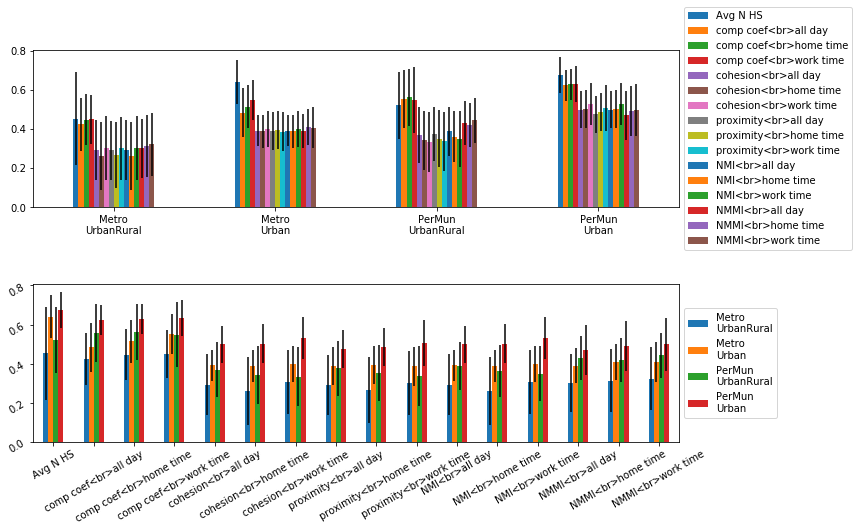

In [624]:
# kendall Tau
# corrleations = [
#     ('Comp Coef', comp_ken_tau), 
#     ('Comp Coef Work', comp_work_ken_tau), 
#     ('Comp Coef Home', comp_home_ken_tau), 
#     ('Avg N HS', nhs_ken_tau)
# ]
corrleations = [('Avg N HS', nhs_ken_tau)]+comp_ken_tau

avers, stds, display_tbl = index_level_tables(corrleations)
display(HTML(pd.DataFrame(display_tbl).style.render().replace('_','<br/>')))

fig, (ax1, ax2) = plt.subplots(ncols=1,nrows=2, 
                               figsize=(12,8))

avers_plot = pd.DataFrame(avers).T
img = avers_plot.plot(ax=ax1, kind='bar',yerr=pd.DataFrame(stds).T).legend(loc='center left', bbox_to_anchor=(1, 0.5))

avers_plot = pd.DataFrame(avers)
img = avers_plot.plot(ax=ax2, kind='bar',yerr=pd.DataFrame(stds)).legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()
ax1.tick_params(labelrotation=0)
ax2.tick_params(labelrotation=30)

plt.savefig('figs/methodLevel_KendallTau.png', bbox_inches='tight')

,"heading level0 col0"" >MetroUrbanRural","heading level0 col1"" >MetroUrban","heading level0 col2"" >PerMunUrbanRural","heading level0 col3"" >PerMunUrban"
"2ef175421b6211ea9c7bd4ae52d07f78level0row0"" class=""rowheading level0 row0"" >Avg N HS","2ef175421b6211ea9c7bd4ae52d07f78row0col0"" class=""data row0 col0"" >0.577 (0.271)","2ef175421b6211ea9c7bd4ae52d07f78row0col1"" class=""data row0 col1"" >0.803 (0.103)","2ef175421b6211ea9c7bd4ae52d07f78row0col2"" class=""data row0 col2"" >0.678 (0.179)","2ef175421b6211ea9c7bd4ae52d07f78row0col3"" class=""data row0 col3"" >0.837 (0.076)"
"2ef175421b6211ea9c7bd4ae52d07f78level0row1"" class=""rowheading level0 row1"" >comp coefall day","2ef175421b6211ea9c7bd4ae52d07f78row1col0"" class=""data row1 col0"" >0.552 (0.167)","2ef175421b6211ea9c7bd4ae52d07f78row1col1"" class=""data row1 col1"" >0.610 (0.162)","2ef175421b6211ea9c7bd4ae52d07f78row1col2"" class=""data row1 col2"" >0.714 (0.167)","2ef175421b6211ea9c7bd4ae52d07f78row1col3"" class=""data row1 col3"" >0.773 (0.083)"
"2ef175421b6211ea9c7bd4ae52d07f78level0row2"" class=""rowheading level0 row2"" >comp coefhome time","2ef175421b6211ea9c7bd4ae52d07f78row2col0"" class=""data row2 col0"" >0.577 (0.149)","2ef175421b6211ea9c7bd4ae52d07f78row2col1"" class=""data row2 col1"" >0.636 (0.148)","2ef175421b6211ea9c7bd4ae52d07f78row2col2"" class=""data row2 col2"" >0.718 (0.163)","2ef175421b6211ea9c7bd4ae52d07f78row2col3"" class=""data row2 col3"" >0.780 (0.082)"
"2ef175421b6211ea9c7bd4ae52d07f78level0row3"" class=""rowheading level0 row3"" >comp coefwork time","2ef175421b6211ea9c7bd4ae52d07f78row3col0"" class=""data row3 col0"" >0.574 (0.144)","2ef175421b6211ea9c7bd4ae52d07f78row3col1"" class=""data row3 col1"" >0.680 (0.125)","2ef175421b6211ea9c7bd4ae52d07f78row3col2"" class=""data row3 col2"" >0.697 (0.194)","2ef175421b6211ea9c7bd4ae52d07f78row3col3"" class=""data row3 col3"" >0.783 (0.098)"
"2ef175421b6211ea9c7bd4ae52d07f78level0row4"" class=""rowheading level0 row4"" >cohesionall day","2ef175421b6211ea9c7bd4ae52d07f78row4col0"" class=""data row4 col0"" >0.401 (0.187)","2ef175421b6211ea9c7bd4ae52d07f78row4col1"" class=""data row4 col1"" >0.533 (0.104)","2ef175421b6211ea9c7bd4ae52d07f78row4col2"" class=""data row4 col2"" >0.494 (0.171)","2ef175421b6211ea9c7bd4ae52d07f78row4col3"" class=""data row4 col3"" >0.644 (0.106)"
"2ef175421b6211ea9c7bd4ae52d07f78level0row5"" class=""rowheading level0 row5"" >cohesionhome time","2ef175421b6211ea9c7bd4ae52d07f78row5col0"" class=""data row5 col0"" >0.354 (0.220)","2ef175421b6211ea9c7bd4ae52d07f78row5col1"" class=""data row5 col1"" >0.529 (0.107)","2ef175421b6211ea9c7bd4ae52d07f78row5col2"" class=""data row5 col2"" >0.457 (0.189)","2ef175421b6211ea9c7bd4ae52d07f78row5col3"" class=""data row5 col3"" >0.648 (0.108)"
"2ef175421b6211ea9c7bd4ae52d07f78level0row6"" class=""rowheading level0 row6"" >cohesionwork time","2ef175421b6211ea9c7bd4ae52d07f78row6col0"" class=""data row6 col0"" >0.412 (0.194)","2ef175421b6211ea9c7bd4ae52d07f78row6col1"" class=""data row6 col1"" >0.546 (0.113)","2ef175421b6211ea9c7bd4ae52d07f78row6col2"" class=""data row6 col2"" >0.445 (0.189)","2ef175421b6211ea9c7bd4ae52d07f78row6col3"" class=""data row6 col3"" >0.669 (0.118)"
"2ef175421b6211ea9c7bd4ae52d07f78level0row7"" class=""rowheading level0 row7"" >proximityall day","2ef175421b6211ea9c7bd4ae52d07f78row7col0"" class=""data row7 col0"" >0.400 (0.186)","2ef175421b6211ea9c7bd4ae52d07f78row7col1"" class=""data row7 col1"" >0.534 (0.127)","2ef175421b6211ea9c7bd4ae52d07f78row7col2"" class=""data row7 col2"" >0.502 (0.173)","2ef175421b6211ea9c7bd4ae52d07f78row7col3"" class=""data row7 col3"" >0.619 (0.108)"
"2ef175421b6211ea9c7bd4ae52d07f78level0row8"" class=""rowheading level0 row8"" >proximityhome time","2ef175421b6211ea9c7bd4ae52d07f78row8col0"" class=""data row8 col0"" >0.367 (0.217)","2ef175421b6211ea9c7bd4ae52d07f78row8col1"" class=""data row8 col1"" >0.539 (0.128)","2ef175421b6211ea9c7bd4ae52d07f78row8col2"" class=""data row8 col2"" >0.

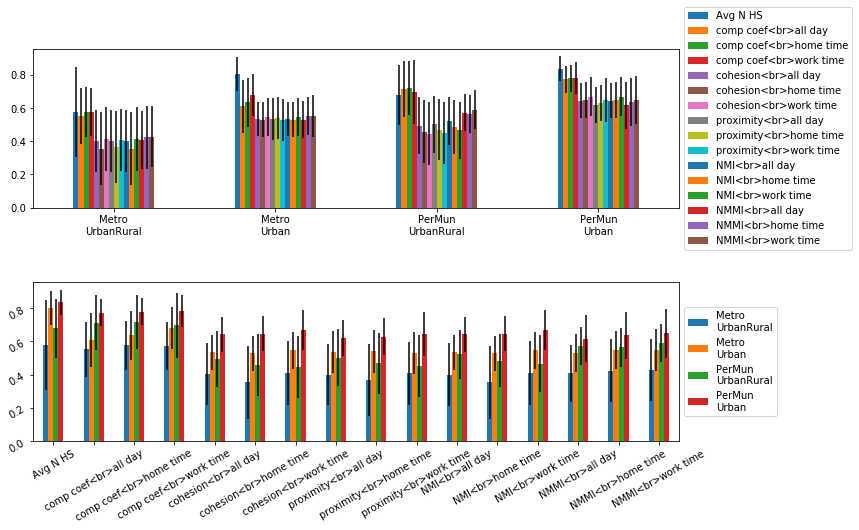

In [238]:
# Spearman Rho
# corrleations = [
#     ('Comp Coef', comp_spr_rho), 
#     ('Comp Coef Work', comp_work_spr_rho), 
#     ('Comp Coef Home', comp_home_spr_rho), 
#     ('Avg N HS', nhs_spr_rho)
# ]
corrleations = [('Avg N HS', nhs_spr_rho)]+comp_spr_rho

avers, stds, display_tbl,error_bars = index_level_tables(corrleations)
display(HTML(pd.DataFrame(display_tbl).style.render().replace('_time','').replace('_','<br/>')))

fig, (ax1, ax2) = plt.subplots(ncols=1,nrows=2,
                               figsize=(12,8))

avers_plot = pd.DataFrame(avers).T
img = avers_plot.plot(ax=ax1, kind='bar',yerr=pd.DataFrame(stds).T).legend(loc='center left', bbox_to_anchor=(1, 0.5))

avers_plot = pd.DataFrame(avers)
img = avers_plot.plot(ax=ax2, kind='bar',yerr=pd.DataFrame(stds)).legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle('std as error bars')
fig.tight_layout()
ax1.tick_params(labelrotation=0)
ax2.tick_params(labelrotation=30)

# plt.savefig('figs/methodLevel_SpearmnRho.png', bbox_inches='tight')

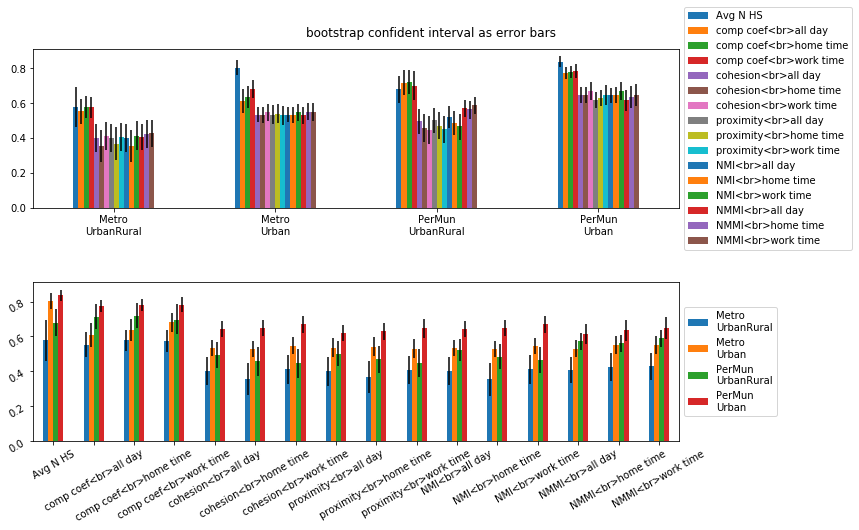

In [251]:
yerr_ci =np.array([pd.DataFrame(df).values.T for df in error_bars.values()])

fig, (ax1, ax2) = plt.subplots(ncols=1,nrows=2,
                               figsize=(12,8))

avers_plot = pd.DataFrame(avers).T
avers_plot.plot(ax=ax1,kind='bar',yerr=yerr_ci.transpose(1,2,0)).legend(loc='center left', bbox_to_anchor=(1, 0.5))

avers_plot = pd.DataFrame(avers)
avers_plot.plot(ax=ax2, kind='bar',yerr=yerr_ci.transpose(0,2,1)).legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle('bootstrap confident interval as error bars')
fig.tight_layout()
ax1.tick_params(labelrotation=0)
ax2.tick_params(labelrotation=30)

plt.savefig('figs/methodLevel_SpearmnRho_conf_interval.png', bbox_inches='tight')

## intra-metro measurements

### rearrange measurements

In [104]:
def hourly_measures_per_metro(sun, geom_type, hs_stats, measure_type, idw=False):
    """
    Measures[measure names (e.g. NMMI)][key_combo (all mun_urb combo, one geom_type, all by)]
    """
    measures = defaultdict(lambda: defaultdict(list))

    for key, stats in hs_stats.items():
        if not idw:
            by, per_mun, urb_only = key
        else:
            by = '_idw10'
            per_mun, urb_only = key
        key_combo = (ADMIN_STR(per_mun, urb_only), geom_type, by)
        if measure_type=='n_hs':
            measures['Avg N HS'][key_combo].extend(hs_stats[key][measure_type][sun]['hourly'].tolist())
        elif measure_type=='compactness':
            for hour in hs_stats[key][measure_type][sun]['hourly']:
                for mname, mvalue in hour.items():
                    if mname=='hour':continue
                    measures[mname][key_combo].append(mvalue)
        else:
            raise ValueError('Not implemented')
    return measures

def hourly_measures_by_mname(geom_type, hs_stats, idws, measure_type, zms):
    """
    all_suns_measures[measure names (e.g. NMMI)][sun_id][key_combo (all mun_urb combo, all geom_type, all by)]
    """
    all_suns_measures = defaultdict(lambda : defaultdict(dict))
    for gtype, hstat, idw in zip(geom_type, hs_stats, idws):
        for sun in sorted(zms.index):
            measures = hourly_measures_per_metro(sun, gtype, hstat,measure_type,idw)
            for mname, measure in measures.items():
                all_suns_measures[mname][sun].update(measure)
    return all_suns_measures

In [105]:
# intra_metro_measures[measure names (e.g. NMMI)][sun_id][key_combo (all mun_urb combo, all geom_type, all by)]
intra_metro_measures = {}

measure_type = 'n_hs'  # another type is average number of hotspot
intra_metro_measures.update(**hourly_measures_by_mname(
    geom_type=['ageb', 'g.5km', 'g.5km', 'vor'],
    hs_stats=[hs_stats_ageb, hs_stats_g, hs_stats_idw, hs_stats_vor],
    idws=[False, False, True, False],
    measure_type=measure_type,
    zms=zms))

measure_type = 'compactness'  # all measurements in compactness: comp_coef, cohesion, proximity, NMI, NMMI
intra_metro_measures.update(**hourly_measures_by_mname(
    geom_type=['ageb', 'g.5km', 'g.5km', 'vor'],
    hs_stats=[hs_stats_ageb, hs_stats_g, hs_stats_idw, hs_stats_vor],
    idws=[False, False, True, False],
    measure_type=measure_type,
    zms=zms))

### compute correlations

In [106]:
# srhos is run on each mun_urb combo and each measurement
def get_srhos_per_astr(astr, intra_metro_measures):
    srhos_per_astr = defaultdict(dict)
    print(astr)
    for mname, one_measure_all_suns in intra_metro_measures.items():
        print(mname, end=' ')
        for sun, measure in one_measure_all_suns.items():
            # TODO: kendall is ill defined when a vector has no ranking (all elements are the same), e.g. sun==9
            # if sun!=9:continue
            # print(sun)

            # extract measure for one mun_urb combo represented as astr
            _, tau = spe_rho_corr(pd.DataFrame(measure)[astr], clean_table=False,larger_than=.0)
            if tau.isnull().values.sum()!=0:
                # 'has ill defined vectors for correlation'
                print(sun, end=' ')
                continue
            srhos_per_astr[mname][sun] = tau
        print()
    #     break
    return srhos_per_astr

### If there is universal pattern across all city-temporal-level comparison

#### Metric level

In [109]:
def stats_of_srhos_for_one_measure(srhos, mname, add_mean=False, aver_first=True):
    n=7
    mean_res = np.ones((n,n), dtype=object)
    for i in range(n):
        for j in range(i+1, n):
            arr = np.array([tmp_srho.iloc[i,j] for tmp_srho in srhos.values()])
            bres = bs.bootstrap(arr, stat_func=bs_stats.mean)
            l_diff = f'{(bres.lower_bound-bres.value):.3f}'
            u_diff = f'{(bres.upper_bound-bres.value):.3f}'
            str_median_quantile = f'{np.median(arr):.3f} <br/>({np.percentile(arr,25):.3f}~{np.percentile(arr,75):.3f})'
            str_mean_std = f'{bres.value:.3f} ({arr.std():.3f})'
            str_conf_inter = f'({bres.lower_bound:.3f}~{bres.upper_bound:.3f})<br/>({l_diff}~{u_diff})'
            str_min_max = f'[{arr.min():.3f}, {arr.max():.3f}]'
            if aver_first:
                mean_res[i,j] = mean_res[j,i] = f'{str_mean_std}<br/>{str_conf_inter}<br/>{str_median_quantile}<br/>{str_min_max}'
            else: 
                mean_res[i,j] = mean_res[j,i] = f'{str_median_quantile}<br/>{str_min_max}<br/>{str_mean_std}<br/>{str_conf_inter}'
                
    #         print(bres.value,arr.std(),i,j)
    #         pd.Series(arr).hist()
    #         plt.show()
    #         break
    #     break
    mean_res = pd.DataFrame(mean_res,index=srhos[1].index, columns=srhos[1].columns)

    mean_res.columns =['<br/>'.join(col).strip() for col in mean_res.columns.values]
    mean_res.index =['<br/>'.join(col).strip() for col in mean_res.index.values]
    mean_res.index.name=mname
    if add_mean:
        mean_res['row<br/>mean'] = (mean_res.applymap(lambda x: float(x.split(' ')[0]) if x!=1 else x).sum(axis=0)-1)/(n-1)
        mean_res['row<br/>mean'] = mean_res['row<br/>mean'].apply(lambda x: f'{x:.03f}')
    return mean_res


In [190]:
srhos_4_astr = [get_srhos_per_astr(astr, intra_metro_measures) for astr in admin_strs]

Metro_UrbanRural
Avg N HS 

/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning:

invalid value encountered in true_divide

/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning:

invalid value encountered in true_divide

/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in greater

/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in less

/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning:

invalid value encountered in less_equal

/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning:

invalid value encountered in less_equal



9 16 29 33 39 54 58 59 
comp_coef 9 16 29 39 54 58 59 
cohesion 9 16 29 39 54 58 59 
proximity 9 16 29 39 54 58 59 
NMI 9 16 29 39 54 58 59 
NMMI 
Metro_Urban
Avg N HS 9 15 16 19 23 29 39 54 58 59 
comp_coef 9 15 16 19 23 29 39 54 58 59 
cohesion 9 15 16 19 23 29 39 54 58 59 
proximity 9 15 16 19 23 29 39 54 58 59 
NMI 9 15 16 19 23 29 39 54 58 59 
NMMI 
PerMun_UrbanRural
Avg N HS 9 23 33 51 54 58 59 
comp_coef 9 16 23 54 58 59 
cohesion 9 16 23 54 58 59 
proximity 9 16 23 54 58 59 
NMI 9 16 23 54 58 59 
NMMI 
PerMun_Urban
Avg N HS 9 15 16 19 20 23 39 40 54 58 59 
comp_coef 9 15 16 19 20 23 39 40 54 58 59 
cohesion 9 15 16 19 20 23 39 40 54 58 59 
proximity 9 15 16 19 20 23 39 40 54 58 59 
NMI 9 15 16 19 20 23 39 40 54 58 59 
NMMI 


In [195]:
i = 3
astr = admin_strs[i]
srhos_per_astr = srhos_4_astr[i]
aver_first = True
print(astr.replace('_','\n'))
print('color by average' if aver_first else 'color by median')

for mname, srhos in srhos_per_astr.items():
    mean_res = stats_of_srhos_for_one_measure(srhos_per_astr[mname], mname, add_mean=True, aver_first=aver_first)
    display(grad_bg_with_str(mean_res, 0, 1, mask_tril=True))

PerMun
Urban
color by average


,agebarea,agebpop,g.5kmarea,g.5kmpop,g.5km_idw10,vorarea,vorpop,rowmean
Avg N HS,,,,,,,,
agebarea,1,"0.503 (0.335)(0.409~0.599)(-0.093~0.096)0.548 (0.231~0.828)[0.000, 0.943]","0.450 (0.384)(0.340~0.558)(-0.110~0.108)0.561 (0.000~0.797)[0.000, 0.991]","0.460 (0.374)(0.355~0.564)(-0.105~0.104)0.566 (0.000~0.805)[0.000, 0.978]","0.186 (0.263)(0.109~0.256)(-0.077~0.070)0.000 (0.000~0.245)[0.000, 0.894]","0.281 (0.303)(0.193~0.362)(-0.088~0.081)0.189 (0.000~0.565)[0.000, 0.947]","0.187 (0.243)(0.115~0.252)(-0.073~0.065)0.041 (0.000~0.332)[0.000, 0.910]",0.345
agebpop,,1,"0.552 (0.327)(0.463~0.644)(-0.090~0.092)0.640 (0.226~0.848)[0.000, 0.978]","0.623 (0.319)(0.535~0.716)(-0.088~0.093)0.751 (0.360~0.884)[0.000, 0.970]","0.185 (0.250)(0.112~0.254)(-0.073~0.069)0.000 (0.000~0.347)[0.000, 0.805]","0.264 (0.323)(0.168~0.351)(-0.096~0.087)0.088 (0.000~0.542)[0.000, 0.895]","0.202 (0.284)(0.117~0.278)(-0.085~0.076)0.037 (0.000~0.292)[0.000, 0.899]",0.388
g.5kmarea,,,1,"0.707 (0.336)(0.617~0.806)(-0.090~0.100)0.828 (0.654~0.944)[0.000, 0.995]","0.237 (0.301)(0.149~0.319)(-0.087~0.082)0.000 (0.000~0.518)[0.000, 0.884]","0.308 (0.341)(0.208~0.403)(-0.100~0.095)0.138 (0.000~0.674)[0.000, 0.957]","0.219 (0.295)(0.134~0.296)(-0.085~0.077)0.000 (0.000~0.434)[0.000, 0.899]",0.412
g.5kmpop,,,,1,"0.231 (0.308)(0.141~0.316)(-0.090~0.085)0.000 (0.000~0.488)[0.000, 0.967]","0.296 (0.348)(0.195~0.392)(-0.100~0.096)0.088 (0.000~0.653)[0.000, 0.972]","0.258 (0.331)(0.162~0.349)(-0.096~0.091)0.011 (0.000~0.581)[0.000, 0.952]",0.429
g.5km_idw10,,,,,1,"0.242 (0.298)(0.155~0.323)(-0.087~0.081)0.051 (0.000~0.448)[0.000, 0.866]","0.285 (0.324)(0.192~0.374)(-0.093~0.089)0.166 (0.000~0.563)[0.000, 0.912]",0.228
vorarea,,,,,,1,"0.603 (0.358)(0.508~0.705)(-0.095~0.102)0.782 (0.329~0.903)[0.000, 0.983]",0.332
vorpop,,,,,,,1,0.292


,agebarea,agebpop,g.5kmarea,g.5kmpop,g.5km_idw10,vorarea,vorpop,rowmean
comp_coef,,,,,,,,
agebarea,1,"0.373 (0.324)(0.285~0.463)(-0.088~0.090)0.290 (0.000~0.661)[0.000, 0.890]","0.350 (0.337)(0.254~0.447)(-0.097~0.097)0.321 (0.000~0.654)[0.000, 0.902]","0.363 (0.315)(0.276~0.451)(-0.087~0.088)0.335 (0.022~0.630)[0.000, 0.923]","0.301 (0.338)(0.203~0.396)(-0.097~0.096)0.130 (0.000~0.650)[0.000, 0.955]","0.280 (0.299)(0.194~0.362)(-0.085~0.082)0.134 (0.000~0.548)[0.000, 0.890]","0.247 (0.286)(0.165~0.325)(-0.082~0.079)0.098 (0.000~0.504)[0.000, 0.853]",0.319
agebpop,,1,"0.356 (0.340)(0.261~0.451)(-0.095~0.095)0.282 (0.000~0.632)[0.000, 0.933]","0.477 (0.346)(0.379~0.574)(-0.098~0.097)0.547 (0.119~0.783)[0.000, 0.957]","0.326 (0.300)(0.240~0.408)(-0.086~0.083)0.321 (0.000~0.521)[0.000, 0.918]","0.283 (0.283)(0.202~0.361)(-0.081~0.078)0.221 (0.000~0.506)[0.000, 0.957]","0.287 (0.254)(0.212~0.357)(-0.075~0.070)0.259 (0.014~0.512)[0.000, 0.798]",0.350
g.5kmarea,,,1,"0.546 (0.313)(0.459~0.636)(-0.087~0.090)0.611 (0.330~0.793)[0.000, 0.972]","0.237 (0.281)(0.156~0.312)(-0.081~0.075)0.133 (0.000~0.435)[0.000, 0.930]","0.257 (0.293)(0.171~0.336)(-0.086~0.079)0.137 (0.000~0.503)[0.000, 0.896]","0.214 (0.268)(0.136~0.286)(-0.078~0.072)0.020 (0.000~0.387)[0.000, 0.851]",0.327
g.5kmpop,,,,1,"0.262 (0.323)(0.165~0.349)(-0.097~0.087)0.060 (0.000~0.598)[0.000, 0.931]","0.283 (0.279)(0.203~0.361)(-0.079~0.078)0.265 (0.000~0.533)[0.000, 0.903]","0.281 (0.277)(0.202~0.358)(-0.080~0.076)0.252 (0.000~0.528)[0.000, 0.866]",0.369
g.5km_idw10,,,,,1,"0.366 (0.329)(0.271~0.459)(-0.094~0.093)0.266 (0.000~0.723)[0.000, 0.936]","0.371 (0.339)(0.276~0.467)(-0.095~0.096)0.384 (0.000~0.702)[0.000, 0.913]",0.310
vorarea,,,,,,1,"0.496 (0.327)(0.404~0.588)(-0.093~0.092)0.557 (0.197~0.785)[0.000, 0.967]",0.327
vorpop,,,,,,,1,0.316


,agebarea,agebpop,g.5kmarea,g.5kmpop,g.5km_idw10,vorarea,vorpop,rowmean
cohesion,,,,,,,,
agebarea,1,"0.370 (0.281)(0.292~0.448)(-0.078~0.078)0.367 (0.089~0.587)[0.000, 0.944]","0.509 (0.340)(0.414~0.607)(-0.095~0.099)0.612 (0.203~0.806)[0.000, 0.936]","0.450 (0.349)(0.352~0.550)(-0.098~0.100)0.489 (0.000~0.742)[0.000, 0.971]","0.194 (0.298)(0.104~0.274)(-0.090~0.080)0.000 (0.000~0.259)[0.000, 0.924]","0.385 (0.294)(0.301~0.468)(-0.084~0.084)0.335 (0.091~0.629)[0.000, 0.897]","0.268 (0.267)(0.191~0.341)(-0.077~0.073)0.231 (0.000~0.419)[0.000, 0.919]",0.363
agebpop,,1,"0.499 (0.300)(0.415~0.585)(-0.084~0.086)0.487 (0.289~0.762)[0.000, 0.943]","0.578 (0.282)(0.499~0.660)(-0.079~0.082)0.591 (0.382~0.821)[0.000, 0.968]","0.249 (0.307)(0.160~0.333)(-0.089~0.084)0.050 (0.000~0.499)[0.000, 0.855]","0.360 (0.275)(0.282~0.436)(-0.077~0.076)0.354 (0.105~0.551)[0.000, 0.921]","0.303 (0.271)(0.225~0.379)(-0.077~0.076)0.281 (0.000~0.498)[0.000, 0.882]",0.393
g.5kmarea,,,1,"0.659 (0.336)(0.567~0.758)(-0.092~0.099)0.800 (0.510~0.916)[0.000, 0.987]","0.251 (0.317)(0.157~0.338)(-0.094~0.087)0.020 (0.000~0.502)[0.000, 0.937]","0.439 (0.334)(0.343~0.534)(-0.095~0.095)0.414 (0.029~0.763)[0.000, 0.927]","0.305 (0.322)(0.215~0.394)(-0.090~0.089)0.198 (0.000~0.614)[0.000, 0.953]",0.444
g.5kmpop,,,,1,"0.294 (0.344)(0.196~0.392)(-0.098~0.098)0.017 (0.000~0.619)[0.000, 0.973]","0.477 (0.299)(0.392~0.562)(-0.085~0.085)0.473 (0.204~0.721)[0.000, 0.944]","0.359 (0.322)(0.268~0.450)(-0.091~0.091)0.327 (0.000~0.638)[0.000, 0.968]",0.470
g.5km_idw10,,,,,1,"0.247 (0.316)(0.154~0.335)(-0.093~0.088)0.008 (0.000~0.571)[0.000, 0.900]","0.253 (0.303)(0.166~0.336)(-0.087~0.083)0.091 (0.000~0.485)[0.000, 0.877]",0.248
vorarea,,,,,,1,"0.426 (0.317)(0.339~0.516)(-0.088~0.090)0.474 (0.114~0.690)[0.000, 0.912]",0.389
vorpop,,,,,,,1,0.319


,agebarea,agebpop,g.5kmarea,g.5kmpop,g.5km_idw10,vorarea,vorpop,rowmean
proximity,,,,,,,,
agebarea,1,"0.386 (0.284)(0.304~0.465)(-0.082~0.079)0.398 (0.103~0.617)[0.000, 0.959]","0.486 (0.354)(0.387~0.587)(-0.099~0.101)0.561 (0.087~0.804)[0.000, 0.953]","0.450 (0.365)(0.347~0.551)(-0.102~0.101)0.507 (0.000~0.785)[0.000, 0.960]","0.215 (0.293)(0.129~0.293)(-0.085~0.078)0.009 (0.000~0.408)[0.000, 0.909]","0.394 (0.298)(0.308~0.478)(-0.086~0.084)0.329 (0.118~0.676)[0.000, 0.901]","0.271 (0.260)(0.194~0.343)(-0.077~0.072)0.239 (0.000~0.473)[0.000, 0.906]",0.367
agebpop,,1,"0.480 (0.306)(0.394~0.568)(-0.086~0.088)0.504 (0.293~0.706)[0.000, 0.944]","0.561 (0.292)(0.480~0.646)(-0.081~0.085)0.584 (0.380~0.811)[0.000, 0.969]","0.244 (0.299)(0.158~0.324)(-0.086~0.080)0.075 (0.000~0.435)[0.000, 0.919]","0.370 (0.282)(0.290~0.449)(-0.080~0.079)0.406 (0.085~0.542)[0.000, 0.922]","0.323 (0.279)(0.243~0.402)(-0.080~0.079)0.287 (0.000~0.560)[0.000, 0.896]",0.394
g.5kmarea,,,1,"0.663 (0.336)(0.572~0.760)(-0.091~0.097)0.801 (0.511~0.927)[0.000, 0.983]","0.250 (0.323)(0.157~0.339)(-0.092~0.089)0.000 (0.000~0.505)[0.000, 0.960]","0.444 (0.342)(0.346~0.538)(-0.098~0.094)0.465 (0.041~0.784)[0.000, 0.926]","0.290 (0.309)(0.201~0.376)(-0.089~0.086)0.215 (0.000~0.580)[0.000, 0.939]",0.435
g.5kmpop,,,,1,"0.289 (0.349)(0.185~0.384)(-0.104~0.095)0.040 (0.000~0.599)[0.000, 0.973]","0.466 (0.317)(0.377~0.556)(-0.089~0.090)0.475 (0.200~0.755)[0.000, 0.951]","0.329 (0.318)(0.238~0.416)(-0.091~0.087)0.266 (0.000~0.598)[0.000, 0.955]",0.460
g.5km_idw10,,,,,1,"0.255 (0.323)(0.163~0.345)(-0.092~0.090)0.012 (0.000~0.580)[0.000, 0.908]","0.265 (0.315)(0.175~0.352)(-0.090~0.087)0.062 (0.000~0.513)[0.000, 0.879]",0.253
vorarea,,,,,,1,"0.422 (0.313)(0.334~0.511)(-0.088~0.088)0.459 (0.086~0.679)[0.000, 0.935]",0.392
vorpop,,,,,,,1,0.317


,agebarea,agebpop,g.5kmarea,g.5kmpop,g.5km_idw10,vorarea,vorpop,rowmean
NMI,,,,,,,,
agebarea,1,"0.370 (0.281)(0.291~0.448)(-0.079~0.077)0.367 (0.089~0.587)[0.000, 0.944]","0.509 (0.340)(0.413~0.608)(-0.096~0.099)0.612 (0.203~0.806)[0.000, 0.936]","0.450 (0.349)(0.351~0.551)(-0.098~0.101)0.489 (0.000~0.742)[0.000, 0.971]","0.194 (0.298)(0.104~0.274)(-0.090~0.081)0.000 (0.000~0.259)[0.000, 0.924]","0.385 (0.294)(0.301~0.468)(-0.084~0.083)0.335 (0.091~0.629)[0.000, 0.897]","0.268 (0.267)(0.191~0.340)(-0.077~0.072)0.231 (0.000~0.419)[0.000, 0.919]",0.363
agebpop,,1,"0.499 (0.300)(0.414~0.585)(-0.085~0.087)0.487 (0.289~0.762)[0.000, 0.943]","0.578 (0.282)(0.501~0.660)(-0.077~0.081)0.591 (0.382~0.821)[0.000, 0.968]","0.249 (0.307)(0.160~0.334)(-0.089~0.085)0.050 (0.000~0.499)[0.000, 0.855]","0.360 (0.275)(0.282~0.435)(-0.078~0.076)0.354 (0.105~0.551)[0.000, 0.921]","0.303 (0.271)(0.225~0.378)(-0.078~0.075)0.281 (0.000~0.498)[0.000, 0.882]",0.393
g.5kmarea,,,1,"0.659 (0.336)(0.566~0.758)(-0.093~0.099)0.800 (0.510~0.916)[0.000, 0.987]","0.251 (0.317)(0.158~0.337)(-0.092~0.087)0.020 (0.000~0.502)[0.000, 0.937]","0.439 (0.334)(0.343~0.532)(-0.096~0.093)0.414 (0.029~0.763)[0.000, 0.927]","0.305 (0.322)(0.213~0.395)(-0.091~0.090)0.198 (0.000~0.614)[0.000, 0.953]",0.444
g.5kmpop,,,,1,"0.294 (0.344)(0.196~0.390)(-0.098~0.096)0.017 (0.000~0.619)[0.000, 0.973]","0.477 (0.299)(0.394~0.563)(-0.083~0.086)0.473 (0.204~0.721)[0.000, 0.944]","0.359 (0.322)(0.266~0.449)(-0.092~0.090)0.327 (0.000~0.638)[0.000, 0.968]",0.470
g.5km_idw10,,,,,1,"0.247 (0.316)(0.157~0.335)(-0.090~0.087)0.008 (0.000~0.571)[0.000, 0.900]","0.253 (0.303)(0.165~0.337)(-0.088~0.084)0.091 (0.000~0.485)[0.000, 0.877]",0.248
vorarea,,,,,,1,"0.426 (0.317)(0.335~0.516)(-0.091~0.089)0.474 (0.114~0.690)[0.000, 0.912]",0.389
vorpop,,,,,,,1,0.319


,agebarea,agebpop,g.5kmarea,g.5kmpop,g.5km_idw10,vorarea,vorpop,rowmean
NMMI,,,,,,,,
agebarea,1,"0.383 (0.322)(0.302~0.464)(-0.081~0.081)0.357 (0.083~0.620)[0.000, 0.999]","0.488 (0.356)(0.399~0.579)(-0.089~0.091)0.550 (0.102~0.804)[0.000, 1.000]","0.332 (0.333)(0.245~0.415)(-0.086~0.083)0.263 (0.000~0.591)[0.000, 1.000]","0.298 (0.328)(0.213~0.380)(-0.085~0.082)0.173 (0.000~0.610)[0.000, 0.934]","0.415 (0.319)(0.335~0.495)(-0.081~0.080)0.337 (0.149~0.691)[0.000, 1.000]","0.336 (0.292)(0.262~0.410)(-0.074~0.074)0.303 (0.000~0.577)[0.000, 1.000]",0.375
agebpop,,1,"0.434 (0.332)(0.350~0.517)(-0.084~0.083)0.490 (0.092~0.738)[0.000, 1.000]","0.564 (0.311)(0.486~0.645)(-0.078~0.081)0.600 (0.365~0.829)[0.000, 0.973]","0.328 (0.305)(0.249~0.407)(-0.080~0.078)0.265 (0.000~0.635)[0.000, 0.961]","0.353 (0.303)(0.275~0.428)(-0.078~0.075)0.317 (0.003~0.580)[0.000, 0.999]","0.415 (0.292)(0.339~0.489)(-0.076~0.074)0.410 (0.136~0.645)[0.000, 0.999]",0.413
g.5kmarea,,,1,"0.498 (0.356)(0.408~0.587)(-0.090~0.089)0.550 (0.084~0.823)[0.000, 1.000]","0.254 (0.303)(0.173~0.332)(-0.081~0.078)0.016 (0.000~0.499)[0.000, 0.948]","0.485 (0.340)(0.400~0.572)(-0.085~0.087)0.563 (0.179~0.765)[0.000, 0.999]","0.407 (0.308)(0.328~0.485)(-0.080~0.078)0.417 (0.146~0.706)[0.000, 0.999]",0.428
g.5kmpop,,,,1,"0.329 (0.327)(0.245~0.411)(-0.084~0.081)0.242 (0.000~0.620)[0.000, 0.962]","0.385 (0.304)(0.307~0.463)(-0.078~0.078)0.335 (0.101~0.657)[0.000, 0.938]","0.431 (0.284)(0.359~0.505)(-0.072~0.074)0.461 (0.215~0.665)[0.000, 0.942]",0.423
g.5km_idw10,,,,,1,"0.231 (0.305)(0.152~0.307)(-0.079~0.076)0.000 (0.000~0.419)[0.000, 0.917]","0.267 (0.337)(0.180~0.351)(-0.087~0.084)0.000 (0.000~0.516)[0.000, 0.937]",0.284
vorarea,,,,,,1,"0.491 (0.339)(0.404~0.576)(-0.087~0.085)0.528 (0.194~0.815)[0.000, 1.000]",0.393
vorpop,,,,,,,1,0.391


#### index-level

In [184]:
n=7  # n methods

def stats_of_srho_index_lvl(srhos_per_astr, aver_first=True):
    tbl = {}
    tbl_aver = {}
    tbl_error_bar = defaultdict(dict)
    for mname,srhos_per_mname in srhos_per_astr.items():
        corr=[]
        for srhos in srhos_per_mname.values():
            for i in range(n):
                for j in range(i+1,n):
                    corr.append(srhos.iloc[i,j])
        corr = np.array(corr)

        bres = bs.bootstrap(corr, stat_func=bs_stats.mean)
        l_diff = f'{(bres.lower_bound-bres.value):.3f}'
        u_diff = f'{(bres.upper_bound-bres.value):.3f}'
        str_median_quantile = f'{np.median(corr):.3f} <br/>({np.percentile(corr,25):.3f}~{np.percentile(corr,75):.3f})'
        str_mean_std = f'{bres.value:.3f} ({corr.std():.3f})'
        str_conf_inter = f'({bres.lower_bound:.3f}~{bres.upper_bound:.3f})<br/>({l_diff}~{u_diff})'
        str_min_max = f'[{corr.min():.3f}, {corr.max():.3f}]'
        if aver_first:
            final_str = f'{str_mean_std}<br/>{str_conf_inter}<br/>{str_median_quantile}<br/>{str_min_max}'
        else: 
            final_str = f'{str_median_quantile}<br/>{str_min_max}<br/>{str_mean_std}<br/>{str_conf_inter}'
        tbl[mname]=final_str
        tbl_aver[mname]= bres.value
        tbl_error_bar['lower'][mname] = bres.value-bres.lower_bound
        tbl_error_bar['upper'][mname] =bres.upper_bound-bres.value
    return tbl, tbl_aver, tbl_error_bar

In [444]:
intra_index_lvl_results = defaultdict(dict)
intra_index_lvl_aver = defaultdict(dict)
intra_index_lvl_error_bar = defaultdict(dict)

for aver_first in [True, False]:
    for i in range(4):
        astr = admin_strs[i]
        srhos_per_astr = srhos_4_astr[i]
        tmp_tbl, tbl_aver, tbl_error_bar = stats_of_srho_index_lvl(srhos_per_astr, aver_first=aver_first)    
        intra_index_lvl_results[aver_first][astr]=tmp_tbl
        intra_index_lvl_aver[aver_first][astr]=tbl_aver
        intra_index_lvl_error_bar[aver_first][astr]=tbl_error_bar
#         break
#     break

In [445]:
print('color by average')
display(grad_bg_with_str(pd.DataFrame(intra_index_lvl_results[True]), 0, 1, mask_tril=False))
print('color by median')
display(grad_bg_with_str(pd.DataFrame(intra_index_lvl_results[False]), 0, 1, mask_tril=False))


color by average


,Metro_UrbanRural,Metro_Urban,PerMun_UrbanRural,PerMun_Urban
Avg N HS,"0.375 (0.382)(0.352~0.398)(-0.023~0.023)0.267 (0.000~0.769)[0.000, 1.000]","0.371 (0.375)(0.348~0.394)(-0.023~0.023)0.278 (0.000~0.747)[0.000, 0.996]","0.319 (0.341)(0.299~0.339)(-0.020~0.020)0.208 (0.000~0.649)[0.000, 0.996]","0.347 (0.356)(0.325~0.368)(-0.022~0.022)0.226 (0.000~0.720)[0.000, 0.995]"
comp_coef,"0.544 (0.335)(0.524~0.564)(-0.020~0.020)0.643 (0.243~0.842)[0.000, 1.000]","0.565 (0.320)(0.546~0.585)(-0.020~0.020)0.671 (0.325~0.844)[0.000, 0.986]","0.296 (0.301)(0.279~0.314)(-0.018~0.018)0.219 (0.000~0.534)[0.000, 0.991]","0.331 (0.320)(0.311~0.351)(-0.020~0.020)0.276 (0.000~0.619)[0.000, 0.972]"
cohesion,"0.248 (0.281)(0.231~0.265)(-0.017~0.017)0.142 (0.000~0.455)[0.000, 0.999]","0.291 (0.289)(0.273~0.308)(-0.018~0.018)0.226 (0.000~0.546)[0.000, 0.973]","0.301 (0.303)(0.283~0.318)(-0.018~0.018)0.232 (0.000~0.546)[0.000, 0.997]","0.375 (0.332)(0.355~0.395)(-0.020~0.020)0.344 (0.000~0.680)[0.000, 0.987]"
proximity,"0.262 (0.290)(0.244~0.279)(-0.017~0.017)0.147 (0.000~0.482)[0.000, 1.000]","0.311 (0.301)(0.293~0.329)(-0.018~0.018)0.252 (0.000~0.573)[0.000, 0.968]","0.299 (0.308)(0.280~0.317)(-0.019~0.019)0.209 (0.000~0.555)[0.000, 0.995]","0.374 (0.334)(0.353~0.394)(-0.021~0.020)0.353 (0.000~0.678)[0.000, 0.983]"
NMI,"0.248 (0.281)(0.232~0.265)(-0.017~0.017)0.142 (0.000~0.457)[0.000, 0.999]","0.291 (0.289)(0.273~0.308)(-0.018~0.018)0.226 (0.000~0.546)[0.000, 0.973]","0.299 (0.301)(0.281~0.317)(-0.018~0.018)0.226 (0.000~0.541)[0.000, 0.997]","0.375 (0.332)(0.355~0.395)(-0.020~0.020)0.344 (0.000~0.680)[0.000, 0.987]"
NMMI,"0.300 (0.308)(0.283~0.318)(-0.017~0.018)0.218 (0.000~0.563)[0.000, 1.000]","0.334 (0.316)(0.316~0.351)(-0.018~0.017)0.272 (0.000~0.630)[0.000, 0.990]","0.354 (0.329)(0.335~0.372)(-0.019~0.019)0.308 (0.000~0.656)[0.000, 0.995]","0.387 (0.331)(0.369~0.406)(-0.018~0.019)0.363 (0.000~0.689)[0.000, 1.000]"


color by median


,Metro_UrbanRural,Metro_Urban,PerMun_UrbanRural,PerMun_Urban
Avg N HS,"0.267 (0.000~0.769)[0.000, 1.000]0.375 (0.382)(0.352~0.398)(-0.023~0.023)","0.278 (0.000~0.747)[0.000, 0.996]0.371 (0.375)(0.348~0.394)(-0.023~0.023)","0.208 (0.000~0.649)[0.000, 0.996]0.319 (0.341)(0.298~0.338)(-0.021~0.020)","0.226 (0.000~0.720)[0.000, 0.995]0.347 (0.356)(0.325~0.368)(-0.022~0.022)"
comp_coef,"0.643 (0.243~0.842)[0.000, 1.000]0.544 (0.335)(0.524~0.565)(-0.020~0.021)","0.671 (0.325~0.844)[0.000, 0.986]0.565 (0.320)(0.546~0.585)(-0.020~0.020)","0.219 (0.000~0.534)[0.000, 0.991]0.296 (0.301)(0.279~0.314)(-0.018~0.017)","0.276 (0.000~0.619)[0.000, 0.972]0.331 (0.320)(0.311~0.351)(-0.020~0.020)"
cohesion,"0.142 (0.000~0.455)[0.000, 0.999]0.248 (0.281)(0.231~0.264)(-0.017~0.016)","0.226 (0.000~0.546)[0.000, 0.973]0.291 (0.289)(0.273~0.308)(-0.018~0.018)","0.232 (0.000~0.546)[0.000, 0.997]0.301 (0.303)(0.283~0.319)(-0.018~0.018)","0.344 (0.000~0.680)[0.000, 0.987]0.375 (0.332)(0.354~0.396)(-0.021~0.021)"
proximity,"0.147 (0.000~0.482)[0.000, 1.000]0.262 (0.290)(0.244~0.278)(-0.017~0.017)","0.252 (0.000~0.573)[0.000, 0.968]0.311 (0.301)(0.292~0.330)(-0.019~0.019)","0.209 (0.000~0.555)[0.000, 0.995]0.299 (0.308)(0.281~0.317)(-0.018~0.018)","0.353 (0.000~0.678)[0.000, 0.983]0.374 (0.334)(0.353~0.394)(-0.021~0.021)"
NMI,"0.142 (0.000~0.457)[0.000, 0.999]0.248 (0.281)(0.232~0.265)(-0.016~0.017)","0.226 (0.000~0.546)[0.000, 0.973]0.291 (0.289)(0.273~0.308)(-0.018~0.018)","0.226 (0.000~0.541)[0.000, 0.997]0.299 (0.301)(0.281~0.317)(-0.018~0.018)","0.344 (0.000~0.680)[0.000, 0.987]0.375 (0.332)(0.355~0.396)(-0.020~0.021)"
NMMI,"0.218 (0.000~0.563)[0.000, 1.000]0.300 (0.308)(0.283~0.318)(-0.017~0.017)","0.272 (0.000~0.630)[0.000, 0.990]0.334 (0.316)(0.316~0.351)(-0.018~0.017)","0.308 (0.000~0.656)[0.000, 0.995]0.354 (0.329)(0.335~0.372)(-0.018~0.018)","0.363 (0.000~0.689)[0.000, 1.000]0.387 (0.331)(0.368~0.405)(-0.019~0.019)"


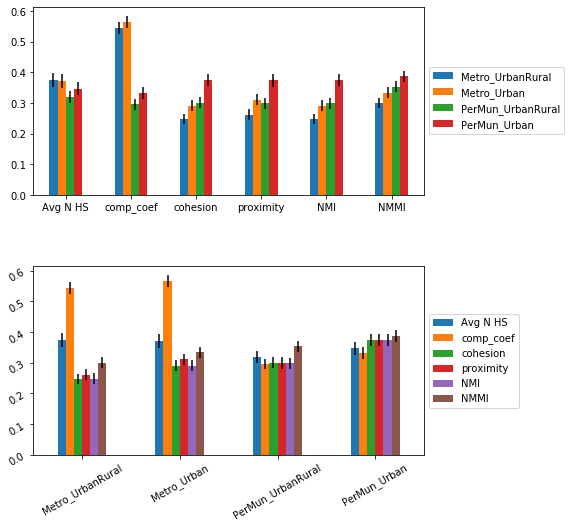

In [494]:

fig, (ax1, ax2) = plt.subplots(ncols=1,nrows=2,figsize=(8,8))
yerr =np.array([pd.DataFrame(df).values.T for df in intra_index_lvl_error_bar[True].values()])
pd.DataFrame(intra_index_lvl_aver[True]).plot(ax=ax1,kind='bar',yerr=yerr).legend(loc='center left', bbox_to_anchor=(1, 0.5))
pd.DataFrame(intra_index_lvl_aver[True]).T.plot(ax=ax2,kind='bar',yerr=yerr.transpose(2,1,0)).legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()
ax1.tick_params(labelrotation=0)
ax2.tick_params(labelrotation=30)


plt.savefig('figs/intra_methodLevel_SpearmnRho.png', bbox_inches='tight')


### cluster-based

#### level of preservation then clustering

In [798]:
weak_tau = 0.3
strong_tau = 0.7
medium_tau = 0.5


In [802]:
def flat_triu(matrix):
    return matrix.values[np.triu_indices(len(matrix),1)]

In [1039]:
measure_type = ['comp_coef', 'cohesion', 'proximity', 'NMI', 'NMMI'][4]
ktaus = ktaus_per_astr[measure_type]

triu_ktaus = {sun:flat_triu(k) for sun, k in ktaus.items()}
triu_ktaus = pd.DataFrame(triu_ktaus).T
triu_ktaus.index.name='zm'
triu_ktaus.columns.name='ktau'

n_none = triu_ktaus.apply(lambda k: (k<weak_tau).sum(), axis=1)
n_weak = triu_ktaus.apply(lambda k: ((k>=weak_tau)&(k<medium_tau)).sum(), axis=1)
n_medium = triu_ktaus.apply(lambda k: ((k>=medium_tau)&(k<strong_tau)).sum(), axis=1)
# n_medium_above = triu_ktaus.apply(lambda k: (k>=medium_tau).sum(), axis=1)
n_strong = triu_ktaus.apply(lambda k: (k>=strong_tau).sum(), axis=1)


triu_ktaus_stats = pd.DataFrame([n_none,n_weak, n_medium, n_strong], index=['None','Weak', 'Medm', 'Strn']).T
disp_df = triu_ktaus_stats.sort_values(['Strn','Medm','Weak'],ascending=False)
disp_df = triu_ktaus_stats.reindex(list(range(1,60)))

print(astr)
print(measure_type)
display(grad_bg(disp_df, format_float=False, mask_tril=False,mini=0, maxi=21))


Metro_Urban
NMMI


,None,Weak,Medm,Strn
zm,,,,
1,14,5,2,0
2,13,1,4,3
3,14,1,5,1
4,2,4,12,3
5,15,2,3,1
6,11,5,4,1
7,15,2,4,0
8,9,5,7,0
9,17,2,2,0


In [1041]:
#
print(astr)
print(measure_type)

c = cluster.OPTICS().fit(triu_ktaus_stats)
print(c.labels_)
cluster_members = pd.DataFrame(np.unique(c.labels_, return_counts=True), index=['c','#']).T.set_index('c')


c_avg = {}
for cl in cluster_members.index.values:
#     if cl ==-1: continue
    c_avg[cl]=triu_ktaus_stats.loc[c.labels_==cl].mean().round(1).astype(str) +' ('+triu_ktaus_stats.loc[c.labels_==cl].std().round(1).astype(str) +')'

cluster_members.join(pd.DataFrame(c_avg).T)

Metro_Urban
NMMI
[ 0 -1 -1 -1  0  0  0 -1  0 -1  0 -1 -1 -1 -1  0 -1 -1 -1 -1 -1  0  0 -1
 -1  0 -1  0 -1 -1  0 -1  0 -1  0  0  0  0  0  0 -1  0 -1  0  0  0  0 -1
  0 -1  0 -1  0  0 -1 -1  0 -1  0]


,#,None,Weak,Medm,Strn
c,,,,,
-1,29,10.3 (4.8),4.1 (3.0),4.9 (3.0),1.7 (1.6)
0,30,14.8 (1.9),3.4 (1.4),2.5 (1.2),0.4 (0.6)


In [1021]:

display(grad_bg(ktaus[4], mask_tril=True,mini=0, maxi=1))


/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning:

invalid value encountered in less



#### clustering on Kendall tau matrix

In [640]:
import sklearn.cluster as cluster

In [716]:
ktaus_per_astr.keys()

dict_keys(['comp_coef', 'cohesion', 'proximity', 'NMI', 'NMMI'])

In [761]:
# clustered = cluster.AgglomerativeClustering(n_clusters=5, affinity='precomputed',linkage='average').fit(dist)
# clustered = cluster.OPTICS(metric='precomputed').fit(dist)

# default settings of minkowski distance seems to be equal to euclidean
# metric = ['braycurtis','chebyshev', 'hamming', 'minkowski'][0]
metric= ['cityblock', 'cosine', 'euclidean', 'l1', 'l2','manhattan'][1]
metric = ['canberra', 'correlation', 'sqeuclidean', ][0]
print('metric =',metric)

labels_for_each_mname = {}
for measure_name in ['comp_coef', 'cohesion', 'proximity', 'NMI', 'NMMI']:
    ktaus = ktaus_per_astr[measure_name]
    ftrs = [k.values[np.triu_indices(len(k),1)] for k in ktaus.values()]
    clustered = cluster.OPTICS(metric=metric).fit(ftrs)
    labels_for_each_mname[measure_name] = clustered.labels_
    

pd.DataFrame({k: pd.Series(v).value_counts().to_dict() for k, v in labels_for_each_mname.items()}).sort_index()

metric = canberra


,comp_coef,cohesion,proximity,NMI,NMMI
-1,41.0,NaN,28,NaN,51.0
0,8.0,49.0,9,49.0,8.0
1,NaN,NaN,6,NaN,NaN
2,NaN,NaN,6,NaN,NaN


In [778]:
measure_name = ['comp_coef', 'cohesion', 'proximity', 'NMI', 'NMMI'][2]
labels = labels_for_each_mname[measure_name]
ktaus = ktaus_per_astr[measure_name]
label_members = np.array(list(ktaus.keys()))[labels==0]
label_members

array([17, 24, 36, 42, 44, 46, 47, 51, 55])

In [779]:
swap_df = ktaus[label_members[0]]
display(grad_bg(swap_df.T.sort_index(level=0).T.sort_index(level=0), mask_tril=True,mini=0, maxi=1))

In [780]:
swap_df = ktaus[label_members[1]]
display(grad_bg(swap_df.T.sort_index(level=0).T.sort_index(level=0), mask_tril=True,mini=0, maxi=1))

# hotspot overlap

## organize avg, geoms

In [19]:
zms_agebs = zms_agebs.merge(mg_mappings[['ageb_id','CVE_SUN']], right_on='ageb_id', left_index=True)

zms_agebs.set_index('ageb_id',inplace=True)

In [20]:
zms_agebs_tmp = {}
zms_agebs_urb = zms_agebs[zms_agebs.Type=="Urban"]
zms_agebs_tmp[(False, False)] = zms_agebs
zms_agebs_tmp[(True, False)] = zms_agebs
zms_agebs_tmp[(False, True)] = zms_agebs_urb
zms_agebs_tmp[(True, True)] = zms_agebs_urb

zms_all_geoms={'ageb': zms_agebs_tmp, 'grid':zms_grids, 'vor': zms_sub_vors}  #[geom_type][(per_mun, urb_only)]

In [21]:
avg_all_geoms={}  # keys: (geom_type, by, per_mun, urb_only)
for per_mun in [False, True]:
    for urb_only in [False, True]:
        avg_all_geoms[('ageb', 'area', per_mun, urb_only)] = avg_a['area']
        avg_all_geoms[('ageb', 'pop', per_mun, urb_only)] = avg_a['pop']
        avg_all_geoms[('grid', 'area', per_mun, urb_only)] = avg_g[('area', per_mun, urb_only)]
        avg_all_geoms[('grid', 'pop', per_mun, urb_only)] = avg_g[('pop', per_mun, urb_only)]
        avg_all_geoms[('grid', '_idw', per_mun, urb_only)] = avg_idw[(per_mun, urb_only)]
        avg_all_geoms[('vor', 'area', per_mun, urb_only)] = avg_vor[('area', per_mun, urb_only)]
        avg_all_geoms[('vor', 'pop', per_mun, urb_only)] = avg_vor[('pop', per_mun, urb_only)]

## get_permanent index for each sun in each method and mun_urb_combo

In [22]:
def get_hs_permanent_index(zms, zms_geoms, avg_geoms, verbose=0, per_mun=False, geom_type='grid', hotspot_type='loubar'):
    permanent_indexes = {}
    for sun in sorted(zms.index):
        print(sun, end=' ')
        zm = zms.loc[sun]
        zm_g = zms_geoms[zms_geoms.CVE_SUN == sun].copy()
        zm_avg_g = avg_geoms.reindex(zm_g.index, fill_value=0).copy()
        hs = ud_helper.ftr_hs.HotSpot(zm_avg_g, zm_g, zm, hotspot_type, verbose=verbose)
        hs_avg = None

        if per_mun:
            hs_avg = []
            for _, mun_g in zm_g.groupby('mun_id'):
                mun_avg_g = avg_geoms.reindex(mun_g.index, fill_value=0).copy()
                # print(sun, mun_g.mun_id.iloc[0],'mun g not in avg', set(mun_g.index) - set(avg_g.index))
                # print('mun_avg_g isnull', mun_avg_g.isnull().sum(), mun_avg_g.shape)
                # TODO: I don't remember why set 10 for grid. 10 doesn't work for Vor, sun 15 always < 10 in PerMun True
                if geom_type == 'grid' and len(mun_g) < 10:
                    continue
                if geom_type == 'vor' and len(mun_g) < 2:
                    continue
                mun_hot = ud_helper.ftr_hs.keep_hotspot(mun_avg_g, hotspot_type)
                hs_avg.append(mun_hot)

            hs_avg = pd.concat(hs_avg).reindex(zm_g.index, fill_value=0)
        
        hs._get_hs(hs_avg)
        hs._hs_type_by_persistence()
        permanent_indexes[sun] = hs.hs_permanent.index.tolist()
    return permanent_indexes

In [23]:
permanent_all_indexes = defaultdict(dict) #  [(per_mun, urb_only)][(geom_type, by)][sun] = indexes of this geom_type in sun
for (geom_type, by, per_mun, urb_only), avg_geoms in avg_all_geoms.items():
#     if per_mun or urb_only: continue
    print(ADMIN_STR(per_mun, urb_only), geom_type, by, end=' ')
    zms_geoms = zms_all_geoms[geom_type][(per_mun, urb_only)]
    permanent_index = get_hs_permanent_index(zms, zms_geoms, avg_geoms, per_mun=per_mun, geom_type=geom_type)
    permanent_all_indexes[(per_mun, urb_only)][(geom_type, by)] = permanent_index
    print()


Metro_UrbanRural ageb area 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
Metro_UrbanRural ageb pop 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
Metro_UrbanRural grid area 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
Metro_UrbanRural grid pop 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
Metro_UrbanRural grid _idw 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
Metro_UrbanRural vor a

## compute overlap score for each per_mun, urb_only combo separetely

In [122]:
def intersection_handling_error(zm_geoms1_union, zm_geoms2_union, msg=None):
    buffer=0
    delta = 1e-10
    while True:
        try:
            if not buffer:
                # first time
                zm_geoms12_inxn = zm_geoms1_union.intersection(zm_geoms2_union)
            else: 
                zm_geoms12_inxn = zm_geoms1_union.buffer(buffer).intersection(zm_geoms2_union.buffer(buffer))
            # successful, break loop
            break
        except TopologicalError:
            buffer += delta
            print(msg,'using buffer:',buffer)
    return zm_geoms12_inxn

In [123]:
def get_overlap_scores(indexes_mun_urb_combo, verbose=0):
    overlap_scores =[]
    for (gt1, by1), (gt2,by2) in combinations(indexes_mun_urb_combo.keys(), 2):
        if verbose: print('method pair', gt1, by1, gt2,by2, end=' ')
        idx1 = indexes_mun_urb_combo[(gt1, by1)]
        idx2 = indexes_mun_urb_combo[(gt2, by2)]
        geoms1 = zms_all_geoms[gt1][(per_mun, urb_only)]
        geoms2 = zms_all_geoms[gt2][(per_mun, urb_only)]
        for sun_id in idx1.keys():
            if verbose: print(sun_id, end=' ')
            zm_idx1 = idx1[sun_id]
            zm_idx2 = idx2[sun_id]
            zm_geoms1 = geoms1.loc[zm_idx1]
            zm_geoms2 = geoms2.loc[zm_idx2]
            zm_geoms1_union = cascaded_union(zm_geoms1.geometry)
            zm_geoms2_union = cascaded_union(zm_geoms2.geometry)
            zm_geoms12_inxn = intersection_handling_error(zm_geoms1_union, zm_geoms2_union, msg=f'({gt1},{by1}), ({gt2},{by2}), {sun_id}')
            overlap_scores.append({'gt1': gt1, 'by1': by1, 'gt2':gt2, 'by2': by2, 'CVE_SUN': sun_id, 
                                   'area1': zm_geoms1_union.area, 'area2': zm_geoms2_union.area,
                                  'area_overlap': zm_geoms12_inxn.area})
    #         break
        if verbose: print()
    #     break
    overlap_scores = pd.DataFrame(overlap_scores)
    overlap_scores['jaccard'] = overlap_scores.area_overlap /(overlap_scores.area1+ overlap_scores.area2 - overlap_scores.area_overlap)
    overlap_scores['overlap_score_norm_by_sum'] = 2* overlap_scores.area_overlap / (overlap_scores.area1+ overlap_scores.area2)
    overlap_scores['overlap_score_norm_by_min'] = overlap_scores.area_overlap / overlap_scores[['area1', 'area2']].min(axis=1)
    return overlap_scores

In [124]:
from shapely.errors import TopologicalError

In [ ]:
all_overlap_scores = {}
for per_mun in [False, True, ]:
    for urb_only in [False, True]:
#         if not per_mun: continue
        astr = ADMIN_STR(per_mun, urb_only)
        print(astr)
        indexes_mun_urb_combo = permanent_all_indexes[(per_mun, urb_only)]
        overlap_scores = get_overlap_scores(indexes_mun_urb_combo)
        all_overlap_scores[astr] = overlap_scores
#         break
#     break
 

Metro_UrbanRural
Metro_Urban
PerMun_UrbanRural


In [522]:
overlap_scores = all_overlap_scores['Metro_Urban']
tmp = overlap_scores[overlap_scores.CVE_SUN==1].sort_values(['gt1','by1','gt2','by2'])
tmp

,gt1,by1,gt2,by2,CVE_SUN,area1,area2,area_overlap,jaccard,overlap_score_norm_by_sum,overlap_score_norm_by_min
0,ageb,area,ageb,pop,1,1.896573e+07,1.768174e+07,8.217604e+06,0.289048,0.448468,0.464751
177,ageb,area,grid,_idw,1,1.896573e+07,3.248503e+06,6.785394e+05,0.031508,0.061091,0.208878
59,ageb,area,grid,area,1,1.896573e+07,7.726606e+06,1.949377e+06,0.078785,0.146063,0.252294
118,ageb,area,grid,pop,1,1.896573e+07,1.022083e+07,1.878265e+06,0.068780,0.128708,0.183768
236,ageb,area,vor,area,1,1.896573e+07,2.468424e+07,8.487464e+06,0.241378,0.388887,0.447516
295,ageb,area,vor,pop,1,1.896573e+07,3.338572e+07,8.617461e+06,0.197043,0.329216,0.454370
472,ageb,pop,grid,_idw,1,1.768174e+07,3.248503e+06,1.119545e+06,0.056512,0.106979,0.344634
354,ageb,pop,grid,area,1,1.768174e+07,7.726606e+06,2.020797e+06,0.086405,0.159066,0.261537
413,ageb,pop,grid,pop,1,1.768174e+07,1.022083e+07,5.665407e+06,0.254772,0.406085,0.554300
531,ageb,pop,vor,area,1,1.768174e+07,2.468424e+07,1.018049e+07,0.316307,0.480597,0.575763


## Analysis index-lvl and method lvl

In [120]:
def stats_str_for_arr(arr, aver_first=True, return_values=True):
    bres = bs.bootstrap(arr, stat_func=bs_stats.mean)
    l_diff = f'{(bres.lower_bound-bres.value):.3f}'
    u_diff = f'{(bres.upper_bound-bres.value):.3f}'
    str_median_quantile = f'{np.median(arr):.3f} <br/>({np.percentile(arr,25):.3f}~{np.percentile(arr,75):.3f})'
    str_mean_std = f'{bres.value:.3f} ({arr.std():.3f})'
    str_conf_inter = f'({bres.lower_bound:.3f}~{bres.upper_bound:.3f})<br/>({l_diff}~{u_diff})'
    str_min_max = f'[{arr.min():.3f}, {arr.max():.3f}]'
    if aver_first:
        final_str = f'{str_mean_std}<br/>{str_conf_inter}<br/>{str_median_quantile}<br/>{str_min_max}'
    else: 
        final_str = f'{str_median_quantile}<br/>{str_min_max}<br/>{str_mean_std}<br/>{str_conf_inter}'
    if return_values:
        return final_str, bres.value, bres.value-bres.lower_bound,bres.upper_bound-bres.value
    else:
        return final_str

### index lvl

In [527]:
ovsc_res = defaultdict(lambda : defaultdict(dict))
tbl_aver = defaultdict(lambda : defaultdict(dict))
tbl_error_bar = defaultdict(lambda : defaultdict(lambda : defaultdict(dict)))
for aver_first in [True, False]:
    for astr, overlap_scores in all_overlap_scores.items():

        mname = 'jaccard'
        fstr, mean, lb, ub = stats_str_for_arr(overlap_scores.jaccard.values,aver_first=aver_first)
        ovsc_res[aver_first][astr][mname] = fstr
        tbl_aver[aver_first][astr][mname]= mean
        tbl_error_bar[aver_first][astr]['lower'][mname] = lb
        tbl_error_bar[aver_first][astr]['upper'][mname] =ub
        
        mname = 'overlap_score<br/>norm_by_sum'
        fstr, mean, lb, ub = stats_str_for_arr(overlap_scores.overlap_score_norm_by_sum.values,aver_first=aver_first)
        ovsc_res[aver_first][astr][mname] = fstr
        tbl_aver[aver_first][astr][mname]= mean
        tbl_error_bar[aver_first][astr]['lower'][mname] = lb
        tbl_error_bar[aver_first][astr]['upper'][mname] =ub
        
        mname = 'overlap_score<br/>norm_by_min'
        fstr, mean, lb, ub = stats_str_for_arr(overlap_scores.overlap_score_norm_by_min.values,aver_first=aver_first)
        ovsc_res[aver_first][astr][mname] = fstr
        tbl_aver[aver_first][astr][mname]= mean
        tbl_error_bar[aver_first][astr]['lower'][mname] = lb
        tbl_error_bar[aver_first][astr]['upper'][mname] =ub
        

In [528]:
print('color by average')
cols = ['Metro_UrbanRural','Metro_Urban','PerMun_UrbanRural','PerMun_Urban']
display_cols = [col.replace('_','<br/>') for col in cols]

tmp_df = pd.concat([pd.DataFrame(intra_index_lvl_results[True]), pd.DataFrame(ovsc_res[True])],sort=False)
tmp_df = pd.DataFrame(ovsc_res[True])[cols]
tmp_df.columns = display_cols
display(grad_bg_with_str(tmp_df, 0, 1, mask_tril=False))
print('color by median')
# tmp_df = pd.concat([pd.DataFrame(intra_index_lvl_results[False]), pd.DataFrame(ovsc_res[False])],sort=False)

tmp_df = pd.DataFrame(ovsc_res[False])[cols]
tmp_df.columns = display_cols
display(grad_bg_with_str(tmp_df, 0, 1, mask_tril=False))


color by average


,MetroUrbanRural,MetroUrban,PerMunUrbanRural,PerMunUrban
jaccard,"0.193 (0.204)(0.181~0.204)(-0.012~0.011)0.135 (0.046~0.271)[0.000, 1.000]","0.237 (0.163)(0.228~0.246)(-0.009~0.009)0.209 (0.119~0.314)[0.000, 1.000]","0.174 (0.171)(0.164~0.183)(-0.010~0.009)0.129 (0.062~0.227)[0.001, 1.000]","0.285 (0.152)(0.276~0.293)(-0.009~0.008)0.264 (0.174~0.365)[0.000, 1.000]"
overlap_scorenorm_by_sum,"0.285 (0.234)(0.272~0.298)(-0.013~0.013)0.238 (0.088~0.427)[0.000, 1.000]","0.358 (0.195)(0.347~0.368)(-0.011~0.011)0.346 (0.213~0.478)[0.000, 1.000]","0.267 (0.202)(0.256~0.278)(-0.011~0.011)0.229 (0.117~0.371)[0.002, 1.000]","0.423 (0.171)(0.413~0.433)(-0.010~0.010)0.418 (0.296~0.535)[0.000, 1.000]"
overlap_scorenorm_by_min,"0.543 (0.256)(0.529~0.558)(-0.014~0.015)0.519 (0.354~0.727)[0.000, 1.000]","0.508 (0.230)(0.495~0.521)(-0.013~0.013)0.487 (0.335~0.665)[0.000, 1.000]","0.539 (0.203)(0.528~0.551)(-0.012~0.011)0.530 (0.402~0.665)[0.008, 1.000]","0.532 (0.181)(0.522~0.543)(-0.010~0.010)0.530 (0.401~0.646)[0.000, 1.000]"


color by median


,MetroUrbanRural,MetroUrban,PerMunUrbanRural,PerMunUrban
jaccard,"0.135 (0.046~0.271)[0.000, 1.000]0.193 (0.204)(0.182~0.204)(-0.011~0.011)","0.209 (0.119~0.314)[0.000, 1.000]0.237 (0.163)(0.228~0.246)(-0.009~0.009)","0.129 (0.062~0.227)[0.001, 1.000]0.174 (0.171)(0.164~0.183)(-0.010~0.009)","0.264 (0.174~0.365)[0.000, 1.000]0.285 (0.152)(0.276~0.293)(-0.008~0.008)"
overlap_scorenorm_by_sum,"0.238 (0.088~0.427)[0.000, 1.000]0.285 (0.234)(0.271~0.298)(-0.013~0.013)","0.346 (0.213~0.478)[0.000, 1.000]0.358 (0.195)(0.347~0.368)(-0.011~0.011)","0.229 (0.117~0.371)[0.002, 1.000]0.267 (0.202)(0.256~0.278)(-0.011~0.011)","0.418 (0.296~0.535)[0.000, 1.000]0.423 (0.171)(0.413~0.433)(-0.010~0.010)"
overlap_scorenorm_by_min,"0.519 (0.354~0.727)[0.000, 1.000]0.543 (0.256)(0.529~0.558)(-0.014~0.014)","0.487 (0.335~0.665)[0.000, 1.000]0.508 (0.230)(0.495~0.521)(-0.013~0.013)","0.530 (0.402~0.665)[0.008, 1.000]0.539 (0.203)(0.528~0.551)(-0.011~0.012)","0.530 (0.401~0.646)[0.000, 1.000]0.532 (0.181)(0.522~0.542)(-0.010~0.010)"


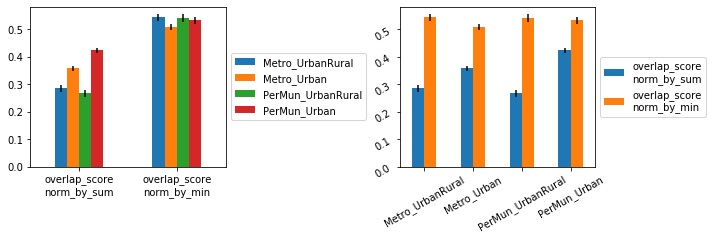

In [499]:

fig, (ax1, ax2) = plt.subplots(ncols=2,nrows=1, figsize=(10,4))
# yerr =    np.array([pd.DataFrame(df).values.T for df in intra_index_lvl_error_bar[True].values()])
yerr = np.array([pd.DataFrame(df).values.T for df in tbl_error_bar[True].values()])
# yerr = np.append(yerr, yerr2, axis=2)

tmp_df = pd.concat([pd.DataFrame(intra_index_lvl_aver[True]), pd.DataFrame(tbl_aver[True])], sort=False)
tmp_df = pd.DataFrame(tbl_aver[True])[cols]
tmp_df.index = [i.replace('<br/>','\n') for i in tmp_df.index]
tmp_df.plot(ax=ax1,kind='bar',yerr=yerr).legend(loc='center left', bbox_to_anchor=(1, 0.5))
tmp_df.T.plot(ax=ax2,kind='bar',yerr=yerr.transpose(2,1,0)).legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()
ax1.tick_params(labelrotation=0)
ax2.tick_params(labelrotation=30)


plt.savefig('figs/intra_methodLevel_Overlap.png', bbox_inches='tight')


In [437]:

display(grad_bg_with_str(pd.DataFrame(ovsc_res), 0, 1, mask_tril=False))


,PerMun_UrbanRural,PerMun_Urban,Metro_UrbanRural,Metro_Urban
overlap_scorenorm_by_sum,"0.267 (0.202)(0.256~0.278)(-0.011~0.011)0.229 (0.117~0.371)[0.002, 1.000]","0.423 (0.171)(0.414~0.433)(-0.009~0.009)0.418 (0.296~0.535)[0.000, 1.000]","0.285 (0.234)(0.272~0.297)(-0.013~0.013)0.238 (0.088~0.427)[0.000, 1.000]","0.358 (0.195)(0.347~0.368)(-0.011~0.011)0.346 (0.213~0.478)[0.000, 1.000]"
overlap_scorenorm_by_min,"0.539 (0.203)(0.528~0.551)(-0.011~0.011)0.530 (0.402~0.665)[0.008, 1.000]","0.532 (0.181)(0.522~0.542)(-0.010~0.010)0.530 (0.401~0.646)[0.000, 1.000]","0.543 (0.256)(0.529~0.558)(-0.014~0.014)0.519 (0.354~0.727)[0.000, 1.000]","0.508 (0.230)(0.495~0.521)(-0.013~0.013)0.487 (0.335~0.665)[0.000, 1.000]"


### method lvl

In [511]:
def get_method_lvl_mats(overlap_scores, aver_first=True, add_mean=True):
    n=7
    mat_sum = np.ones((n,n)).astype(object)
    mat_min = np.ones((n,n)).astype(object)
    for (gt1,by1,gt2,by2), method_flattened_matrix in overlap_scores.groupby(['gt1','by1','gt2','by2']):
        m1 = gt1+'<br/>'+by1
        m2 = gt2+'<br/>'+by2
        i = method_order[m1]
        j = method_order[m2]
        mat_min[i,j] = mat_min[j,i] = stats_str_for_arr(method_flattened_matrix.overlap_score_norm_by_min.values,aver_first=aver_first,return_values=False)
        mat_sum[i,j] = mat_sum[j,i] = stats_str_for_arr(method_flattened_matrix.overlap_score_norm_by_sum.values,aver_first=aver_first,return_values=False)
    mat_min = pd.DataFrame(mat_min, index=method_names, columns=method_names)
    mat_min.index.name = 'overlap_score<br/>norm_by_min'
    mat_sum = pd.DataFrame(mat_sum, index=method_names, columns=method_names)
    mat_sum.index.name = 'overlap_score<br/>norm_by_sum'
    
    if add_mean:
        mat_sum['row<br/>mean'] = (mat_sum.applymap(lambda x: float(x.split(' ')[0]) if x!=1 else x).sum(axis=0)-1)/(n-1)
        mat_sum['row<br/>mean'] = mat_sum['row<br/>mean'].apply(lambda x: f'{x:.03f}')
        mat_min['row<br/>mean'] = (mat_min.applymap(lambda x: float(x.split(' ')[0]) if x!=1 else x).sum(axis=0)-1)/(n-1)
        mat_min['row<br/>mean'] = mat_min['row<br/>mean'].apply(lambda x: f'{x:.03f}')
    
    return mat_min, mat_sum

In [517]:
i = 3
astr = admin_strs[i]
overlap_scores = all_overlap_scores2[astr]
mat_min, mat_sum = get_method_lvl_mats(overlap_scores, aver_first=False, add_mean=True)
print(astr.replace('_', '\n'))
display(grad_bg_with_str(mat_sum, 0, 1, mask_tril=True))
display(grad_bg_with_str(mat_min, 0, 1, mask_tril=True))

PerMun
Urban


,agebarea,agebpop,grid_idw,gridarea,gridpop,vorarea,vorpop,rowmean
overlap_scorenorm_by_sum,,,,,,,,
agebarea,1,"0.519 (0.383~0.608)[0.085, 0.849]0.513 (0.162)(0.472~0.555)(-0.041~0.042)","0.316 (0.254~0.461)[0.048, 0.607]0.332 (0.133)(0.298~0.367)(-0.034~0.035)","0.493 (0.371~0.588)[0.213, 0.800]0.496 (0.140)(0.461~0.532)(-0.035~0.036)","0.248 (0.180~0.339)[0.073, 0.707]0.276 (0.137)(0.239~0.310)(-0.037~0.034)","0.437 (0.357~0.559)[0.117, 0.708]0.451 (0.139)(0.416~0.487)(-0.034~0.036)","0.320 (0.243~0.436)[0.101, 0.672]0.344 (0.143)(0.307~0.380)(-0.037~0.036)",0.389
agebpop,,1,"0.344 (0.286~0.458)[0.156, 0.618]0.369 (0.118)(0.339~0.399)(-0.030~0.030)","0.454 (0.367~0.536)[0.176, 0.746]0.452 (0.124)(0.421~0.484)(-0.031~0.032)","0.492 (0.394~0.581)[0.276, 0.751]0.493 (0.112)(0.466~0.522)(-0.028~0.028)","0.355 (0.262~0.471)[0.168, 0.621]0.371 (0.122)(0.340~0.402)(-0.031~0.031)","0.351 (0.243~0.473)[0.123, 0.621]0.366 (0.138)(0.331~0.401)(-0.035~0.035)",0.419
grid_idw,,,1,"0.450 (0.362~0.529)[0.174, 0.727]0.448 (0.113)(0.419~0.476)(-0.029~0.029)","0.422 (0.319~0.516)[0.140, 0.756]0.417 (0.132)(0.383~0.451)(-0.034~0.034)","0.376 (0.305~0.460)[0.090, 0.625]0.372 (0.128)(0.339~0.404)(-0.033~0.033)","0.350 (0.246~0.447)[0.043, 0.610]0.344 (0.131)(0.311~0.378)(-0.033~0.033)",0.376
gridarea,,,,1,"0.589 (0.507~0.650)[0.255, 0.833]0.562 (0.134)(0.529~0.596)(-0.034~0.034)","0.508 (0.386~0.681)[0.142, 0.921]0.525 (0.189)(0.478~0.574)(-0.048~0.049)","0.345 (0.198~0.495)[0.073, 0.790]0.358 (0.184)(0.309~0.404)(-0.049~0.045)",0.473
gridpop,,,,,1,"0.353 (0.281~0.450)[0.203, 0.652]0.371 (0.114)(0.342~0.401)(-0.029~0.030)","0.342 (0.256~0.455)[0.108, 0.652]0.354 (0.139)(0.318~0.389)(-0.036~0.036)",0.408
vorarea,,,,,,1,"0.718 (0.509~0.844)[0.000, 1.000]0.668 (0.240)(0.608~0.731)(-0.061~0.063)",0.458
vorpop,,,,,,,1,0.404


,agebarea,agebpop,grid_idw,gridarea,gridpop,vorarea,vorpop,rowmean
overlap_scorenorm_by_min,,,,,,,,
agebarea,1,"0.572 (0.463~0.714)[0.102, 0.923]0.575 (0.172)(0.531~0.619)(-0.043~0.044)","0.370 (0.305~0.516)[0.055, 0.809]0.399 (0.150)(0.360~0.437)(-0.039~0.038)","0.582 (0.511~0.671)[0.216, 0.903]0.585 (0.133)(0.551~0.619)(-0.033~0.034)","0.345 (0.264~0.470)[0.091, 0.728]0.353 (0.147)(0.316~0.390)(-0.038~0.037)","0.505 (0.443~0.605)[0.128, 0.862]0.525 (0.152)(0.486~0.564)(-0.038~0.039)","0.428 (0.352~0.536)[0.128, 0.998]0.443 (0.156)(0.401~0.482)(-0.042~0.039)",0.467
agebpop,,1,"0.466 (0.322~0.529)[0.165, 0.756]0.437 (0.134)(0.402~0.471)(-0.034~0.034)","0.526 (0.419~0.621)[0.194, 0.833]0.523 (0.139)(0.488~0.559)(-0.035~0.036)","0.598 (0.509~0.655)[0.345, 0.802]0.594 (0.098)(0.569~0.619)(-0.025~0.025)","0.444 (0.341~0.565)[0.204, 0.866]0.464 (0.145)(0.426~0.500)(-0.037~0.037)","0.504 (0.386~0.580)[0.204, 0.850]0.498 (0.146)(0.460~0.535)(-0.038~0.037)",0.518
grid_idw,,,1,"0.556 (0.436~0.635)[0.181, 0.847]0.542 (0.141)(0.507~0.578)(-0.035~0.036)","0.532 (0.399~0.614)[0.199, 0.847]0.520 (0.151)(0.481~0.559)(-0.038~0.039)","0.491 (0.376~0.583)[0.118, 0.863]0.489 (0.158)(0.449~0.530)(-0.040~0.041)","0.524 (0.397~0.611)[0.118, 0.881]0.503 (0.144)(0.467~0.539)(-0.036~0.036)",0.490
gridarea,,,,1,"0.674 (0.570~0.734)[0.275, 0.894]0.646 (0.143)(0.610~0.683)(-0.036~0.038)","0.678 (0.561~0.806)[0.175, 0.965]0.663 (0.182)(0.617~0.710)(-0.047~0.046)","0.504 (0.390~0.641)[0.175, 0.991]0.512 (0.178)(0.465~0.556)(-0.046~0.044)",0.587
gridpop,,,,,1,"0.483 (0.409~0.609)[0.305, 0.813]0.514 (0.135)(0.480~0.548)(-0.035~0.034)","0.564 (0.474~0.648)[0.332, 0.983]0.578 (0.141)(0.542~0.614)(-0.037~0.036)",0.533
vorarea,,,,,,1,"0.878 (0.727~0.988)[0.000, 1.000]0.817 (0.218)(0.765~0.876)(-0.052~0.059)",0.580
vorpop,,,,,,,1,0.567


## deprecated

##### Method level

In [369]:
per_pair_method_overlap_score = overlap_scores.groupby(['gt1','by1','gt2','by2']).agg({'overlap_score_norm_by_sum':['mean','std'], 'overlap_score_norm_by_min': ['mean','std']})

In [1216]:
per_pair_method_overlap_score_mean = per_pair_method_overlap_score.loc[:, pd.IndexSlice[:,'mean']]
per_pair_method_overlap_score_mean.columns = ['by_sum','by_min']
# per_pair_method_overlap_score_mean=per_pair_method_overlap_score_mean.sort_values('by_sum')


per_pair_method_overlap_score_std = per_pair_method_overlap_score.loc[:, pd.IndexSlice[:,'std']]
per_pair_method_overlap_score_std.columns = ['by_sum','by_min']
# per_pair_method_overlap_score_std =per_pair_method_overlap_score_std.loc[per_pair_method_overlap_score_mean.index]

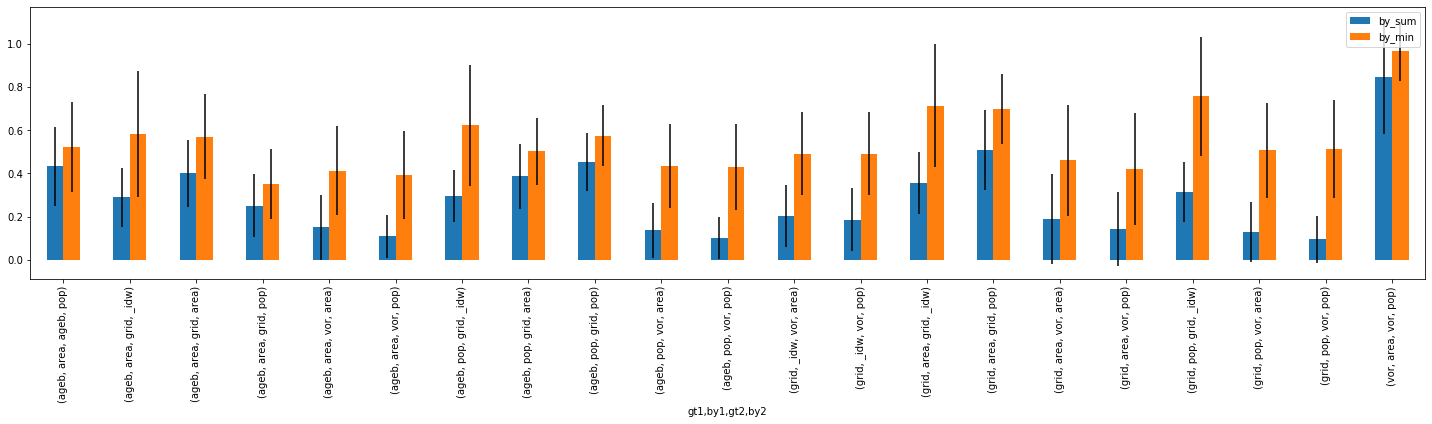

In [1220]:
per_pair_method_overlap_score_mean.plot(kind='bar',figsize=(25,5), yerr=per_pair_method_overlap_score_std)

##### overlap levels count

In [266]:
ovlp_weak = 0.3
ovlp_medm = 0.5
ovlp_strn = 0.7

In [267]:
scol = 'overlap_score_norm_by_min'
overlap_scores['None'] = overlap_scores[scol].apply(lambda x: x<ovlp_weak)
overlap_scores['Weak'] = overlap_scores[scol].apply(lambda x: ovlp_weak<=x<ovlp_medm)
overlap_scores['Medm'] = overlap_scores[scol].apply(lambda x: ovlp_medm<=x<ovlp_strn)
overlap_scores['Strn'] = overlap_scores[scol].apply(lambda x: x>=ovlp_strn)


In [268]:
print(ADMIN_STR(per_mun, urb_only), scol)
slvl_count = []
for sun_id, sun_overlap_score in overlap_scores.groupby('CVE_SUN'):
    slvl_count.append({
        'CVE_SUN': sun_id,
        'None': sun_overlap_score['None'].sum(),
        'Weak': sun_overlap_score.Weak.sum(),
        'Medm': sun_overlap_score.Medm.sum(),
        'Strn': sun_overlap_score.Strn.sum(),
    })
#     break


slvl_count=pd.DataFrame(slvl_count).set_index('CVE_SUN')

Metro_Urban overlap_score_norm_by_min


In [269]:
print(ADMIN_STR(per_mun, urb_only))
print(scol)

display(grad_bg(slvl_count, format_float=False, mask_tril=False,mini=0, maxi=21))

Metro_Urban
overlap_score_norm_by_min


,None,Weak,Medm,Strn
CVE_SUN,,,,
1,5,6,9,1
2,8,5,6,2
3,1,12,6,2
4,6,12,2,1
5,8,9,3,1
6,2,7,5,7
7,1,5,14,1
8,8,7,3,3
9,2,5,3,11


In [1291]:
print(ADMIN_STR(per_mun, urb_only), scol)

c = cluster.OPTICS().fit(slvl_count)
print(c.labels_)
cluster_members = pd.DataFrame(np.unique(c.labels_, return_counts=True), index=['c','#']).T.set_index('c')


c_avg = {}
for cl in cluster_members.index.values:
#     if cl ==-1: continue
    c_avg[cl]=slvl_count.loc[c.labels_==cl].mean().round(1).astype(str) +' ('+slvl_count.loc[c.labels_==cl].std().round(1).astype(str) +')'

cluster_members.join(pd.DataFrame(c_avg).T)

Metro_Urban overlap_score_norm_by_min
[-1  1  0 -1 -1  2 -1 -1  2 -1  0 -1 -1 -1  1 -1  2  0 -1 -1 -1 -1 -1 -1
  0 -1 -1  1 -1  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2 -1 -1  0 -1 -1  2
  2 -1  0  0  2 -1  1  1 -1 -1  2]


,#,None,Weak,Medm,Strn
c,,,,,
-1,38,4.7 (4.2),6.0 (2.8),6.0 (3.7),4.3 (4.3)
0,7,2.4 (1.0),10.4 (0.8),5.9 (0.7),2.3 (1.0)
1,5,8.2 (0.8),5.2 (0.8),5.8 (1.3),1.8 (0.4)
2,9,2.2 (1.5),5.9 (2.0),4.6 (1.9),8.3 (1.6)


##### overlap score can be aggregate per city

In [1183]:
per_city_overlap_score = overlap_scores.groupby('CVE_SUN').agg({'overlap_score_norm_by_sum':['mean','std'], 'overlap_score_norm_by_min': ['mean','std']})

In [1205]:
per_city_overlap_score_mean = per_city_overlap_score.loc[:, pd.IndexSlice[:,'mean']]
per_city_overlap_score_mean.columns = ['by_sum','by_min']
per_city_overlap_score_mean=per_city_overlap_score_mean.sort_values('by_sum')


In [1207]:
per_city_overlap_score_std = per_city_overlap_score.loc[:, pd.IndexSlice[:,'std']]
per_city_overlap_score_std.columns = ['by_sum','by_min']
per_city_overlap_score_std =per_city_overlap_score_std.loc[per_city_overlap_score_mean.index]

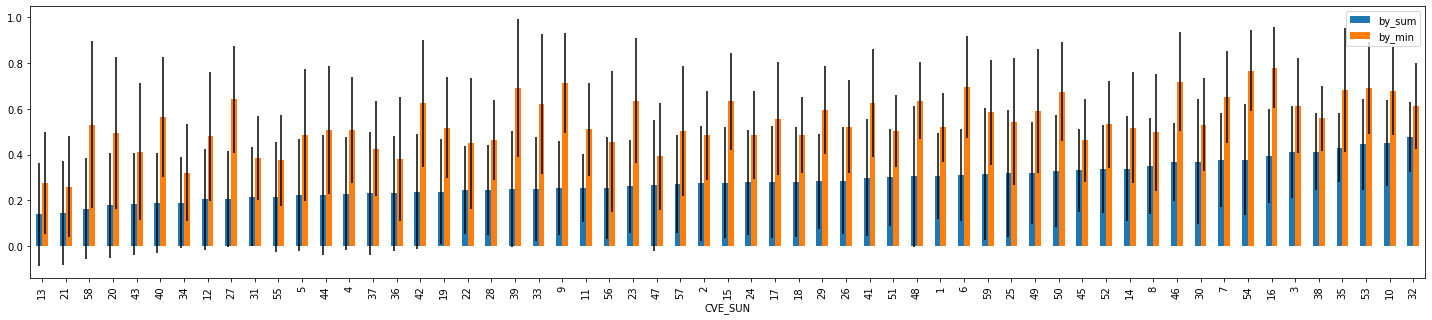

In [1208]:
per_city_overlap_score_mean.plot(kind='bar',figsize=(25,5), yerr=per_city_overlap_score_std)

# permanent hotspot temporal ranking evolution

In [26]:
from numba import njit

In [27]:
@njit
def spear_weighted(x, y, w):
    n = len(x)
    sum_ab = 0
    sum_aa = 0
    sum_bb = 0
    for i in range(n):
        for j in range(i + 1, n):
            wij = w[i,j]
            aij = x[j] - x[i]
            bij = y[j] - y[i]
            sum_ab += aij * bij * wij
            sum_aa += aij**2 * wij
            sum_bb += bij**2 * wij
    return sum_ab / np.sqrt(sum_aa*sum_bb)

In [552]:
# defined in section "hotspot overlap"
# permanent_all_indexes  # [(per_mun, urb_only)][(geom_type, by)][sun] = indexes of this geom_type in sun
# avg_all_geoms  # keys: (geom_type, by, per_mun, urb_only)
# zms_all_geoms={'ageb': zms_agebs_tmp, 'grid':zms_grids, 'vor': zms_sub_vors}  #[geom_type][(per_mun, urb_only)]

In [171]:
def temporal_change(avg, weight):
    temporal_res = []
    for tod in range(n_bins):
        tod_next = str((tod + 1) % tod_bins)
        tod = str(tod)
        rho, _ = spearmanr(avg[tod], avg[tod_next])
        tau, _ = kendalltau(avg[tod], avg[tod_next])
        wrho = spear_weighted(avg[tod].values, avg[tod_next].values, weight)
        temporal_res.append({
            'tod': f'{tod}~{tod_next}',
            'rho': rho,
#             'tau': tau,
            'weighted_rho': wrho
        })
    return temporal_res

## compute n_bins-dim vector of temporal evolution

In [172]:
# [astr][sun_id][type_of_measure] = n_bins-dim vector of evolution between pairs of hour-bins
all_temporal_evolution = defaultdict(lambda : defaultdict(lambda: defaultdict(dict)))
for per_mun, urb_only in [(False, False), (False, True), (True, False), (True, True)]:
    astr = ADMIN_STR(per_mun, urb_only)
    print('='*20, astr)
    for method in method_names:
        geom_type, by = method.split('<br/>')
        per_idx = permanent_all_indexes[(per_mun, urb_only)][(geom_type, by)]
        for sun_id, per_idx_zm in per_idx.items():
            # TODO: what is the minimum amount of hotspot to compute temporal evolution?
            if len(per_idx_zm)<=1:
                print(f'zm {sun_id} has {len(per_idx_zm)} permanent hotspot in {astr}, {geom_type}, {by}, skipped')
                continue
            per_geom_zm = zms_all_geoms[geom_type][(per_mun, urb_only)].loc[per_idx_zm]
            per_weight = 1 / ((ud_helper.ftr_hs.gis.polys_centroid_pairwise_dist(per_geom_zm, per_geom_zm.crs)+1e-9)/1000)
            per_avg_zm = avg_all_geoms[(geom_type, by, per_mun, urb_only)].loc[per_idx_zm]
            t_evol = pd.DataFrame(temporal_change(per_avg_zm, per_weight))
            all_temporal_evolution[astr][sun_id]['rho'][(geom_type, by)] = t_evol.rho.values
#             all_temporal_evolution[astr][sun_id]['tau'][(geom_type, by)] = t_evol.tau.values
            all_temporal_evolution[astr][sun_id]['weighted_rho'][(geom_type, by)] = t_evol.weighted_rho.values

==================== Metro_UrbanRural
zm 15 has 1 permanent hotspot in Metro_UrbanRural, vor, area, skipped
zm 33 has 1 permanent hotspot in Metro_UrbanRural, vor, area, skipped
zm 54 has 1 permanent hotspot in Metro_UrbanRural, vor, area, skipped
zm 58 has 1 permanent hotspot in Metro_UrbanRural, vor, area, skipped
zm 59 has 1 permanent hotspot in Metro_UrbanRural, vor, area, skipped
zm 15 has 1 permanent hotspot in Metro_UrbanRural, vor, pop, skipped
zm 19 has 1 permanent hotspot in Metro_UrbanRural, vor, pop, skipped
zm 39 has 1 permanent hotspot in Metro_UrbanRural, vor, pop, skipped
zm 58 has 1 permanent hotspot in Metro_UrbanRural, vor, pop, skipped
zm 59 has 1 permanent hotspot in Metro_UrbanRural, vor, pop, skipped
==================== Metro_Urban
zm 9 has 1 permanent hotspot in Metro_Urban, vor, area, skipped
zm 15 has 1 permanent hotspot in Metro_Urban, vor, area, skipped
zm 19 has 1 permanent hotspot in Metro_Urban, vor, area, skipped
zm 23 has 1 permanent hotspot in Metro_U

## based on nbin-dim vector, compare stability between vectors from diff methods

In [173]:
n_methods = len(method_names)
# [astr][measure_name][sun_id] = flatten_matrix (index=method_names, columns=method_names)
all_temporal_evol_comparison_flatten_matrix = defaultdict(lambda: defaultdict(dict))
for astr, temporal_evolution in all_temporal_evolution.items():
    for sun_id, t_evol_zm in temporal_evolution.items():
        for measure_name, t_evol_zm_vecs in t_evol_zm.items():
            flatten_matrix = np.ones((n_methods, n_methods))
            for i in range(n_methods):
                for j in range(i+1, n_methods):
                    gt1, by1 = method_names[i].split('<br/>')
                    gt2, by2 = method_names[j].split('<br/>')
                    if (gt1, by1) not in t_evol_zm_vecs or (gt2, by2) not in t_evol_zm_vecs:
                        flatten_matrix[i,j] = flatten_matrix[j,i] = None
                    else:
                        vec1 = t_evol_zm_vecs[(gt1, by1)]
                        vec2 = t_evol_zm_vecs[(gt2, by2)]
                        rho, _ = spearmanr(vec1, vec2)
                        flatten_matrix[i,j] = flatten_matrix[j,i] = rho
            all_temporal_evol_comparison_flatten_matrix[astr][measure_name][sun_id] = flatten_matrix

/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning:

invalid value encountered in true_divide

/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning:

invalid value encountered in true_divide

/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in greater

/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in less

/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning:

invalid value encountered in less_equal



In [174]:
grad_bg(pd.DataFrame(all_temporal_evol_comparison_flatten_matrix[astr]['weighted_rho'][1], index=method_names, columns=method_names),mini=0,maxi=1)

,agebarea,agebpop,grid_idw,gridarea,gridpop,vorarea,vorpop
agebarea,1.000,0.939,0.863,0.771,0.788,0.877,0.843
agebpop,0.939,1.000,0.945,0.873,0.910,0.863,0.838
grid_idw,0.863,0.945,1.000,0.854,0.883,0.806,0.813
gridarea,0.771,0.873,0.854,1.000,0.971,0.695,0.729
gridpop,0.788,0.910,0.883,0.971,1.000,0.737,0.773
vorarea,0.877,0.863,0.806,0.695,0.737,1.000,0.955
vorpop,0.843,0.838,0.813,0.729,0.773,0.955,1.000


## index-lvl temporal evolution stability

In [175]:
def get_flat_triu(mat, remove_na=True):
    assert mat.shape[0]==mat.shape[1]
    arr = []
    n = mat.shape[1]
    for i in range(n):
        for j in range(i+1,n):
            if remove_na and pd.isnull(mat[i,j]): continue
            arr.append(mat[i,j])
    return arr

In [121]:
# stats_str_for_arr  defined in 7.4 Analysis index-lvl and method-lvl

In [176]:

temp_evol_res = defaultdict(lambda : defaultdict(dict))  # [aver_first][astr][measure_name]
tbl_aver = defaultdict(lambda : defaultdict(dict))  # [aver_first][astr][measure_name]
tbl_error_bar = defaultdict(lambda : defaultdict(lambda : defaultdict(dict)))  # [aver_first][astr][lower/upper][measure_name]

for aver_first in [True, False]:
    for astr, measure_stability in all_temporal_evol_comparison_flatten_matrix.items():
        for measure_name, stability_matrixes in measure_stability.items():
            arr = []
            for sun_id, mat in stability_matrixes.items():
                arr.extend(get_flat_triu(mat))
            fstr, mean, lb, ub = stats_str_for_arr(np.array(arr),aver_first=aver_first)
            temp_evol_res[aver_first][astr][measure_name] = fstr
            tbl_aver[aver_first][astr][measure_name]= mean
            tbl_error_bar[aver_first][astr]['lower'][measure_name] = lb
            tbl_error_bar[aver_first][astr]['upper'][measure_name] =ub

In [184]:
# tables
print('color by average')
cols = ['Metro_UrbanRural','Metro_Urban','PerMun_UrbanRural','PerMun_Urban']
display_cols = [col.replace('_','<br/>') for col in cols]

tmp_df = pd.DataFrame(temp_evol_res[True]).loc[['weighted_rho'],cols]
tmp_df.columns = display_cols
display(grad_bg_with_str(tmp_df, 0, 1, mask_tril=False))
print('color by median')

tmp_df = pd.DataFrame(temp_evol_res[False]).loc[['weighted_rho'],cols]
tmp_df.columns = display_cols
display(grad_bg_with_str(tmp_df, 0, 1, mask_tril=False))


color by average


,MetroUrbanRural,MetroUrban,PerMunUrbanRural,PerMunUrban
weighted_rho,"0.787 (0.239)(0.774~0.801)(-0.013~0.014)0.864 (0.727~0.941)[-0.398, 1.000]","0.787 (0.231)(0.774~0.800)(-0.013~0.013)0.864 (0.739~0.931)[-0.336, 0.999]","0.817 (0.225)(0.805~0.830)(-0.012~0.013)0.897 (0.782~0.950)[-0.228, 1.000]","0.794 (0.264)(0.780~0.809)(-0.015~0.015)0.893 (0.782~0.947)[-0.354, 1.000]"


color by median


,MetroUrbanRural,MetroUrban,PerMunUrbanRural,PerMunUrban
weighted_rho,"0.864 (0.727~0.941)[-0.398, 1.000]0.787 (0.239)(0.774~0.801)(-0.013~0.014)","0.864 (0.739~0.931)[-0.336, 0.999]0.787 (0.231)(0.774~0.801)(-0.013~0.014)","0.897 (0.782~0.950)[-0.228, 1.000]0.817 (0.225)(0.805~0.830)(-0.012~0.013)","0.893 (0.782~0.947)[-0.354, 1.000]0.794 (0.264)(0.780~0.809)(-0.014~0.015)"


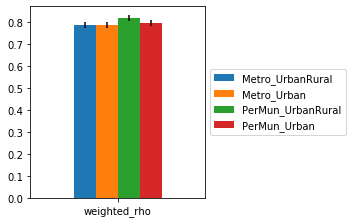

In [197]:
# plot
fig, ax = plt.subplots(ncols=1,nrows=1, figsize=(5,4))
# yerr =    np.array([pd.DataFrame(df).values.T for df in intra_index_lvl_error_bar[True].values()])
yerr = np.array([pd.DataFrame(df).loc[['weighted_rho']].values.T for df in tbl_error_bar[True].values()])
# yerr = np.append(yerr, yerr2, axis=2)

tmp_df = pd.DataFrame(tbl_aver[True]).loc[['weighted_rho'],cols]
tmp_df.index = [i.replace('<br/>','\n') for i in tmp_df.index]
tmp_df.plot(ax=ax,kind='bar',yerr=yerr).legend(loc='center left', bbox_to_anchor=(1, 0.5))
# tmp_df.T.plot(ax=ax,kind='bar',yerr=yerr.transpose(2,1,0)).legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()
# ax1.tick_params(labelrotation=0)
ax.tick_params(labelrotation=0)


plt.savefig('figs/intra_methodLevel_TemporalEvolution.png', bbox_inches='tight')


## method-level

In [198]:
def get_method_lvl_stats(stability_matrixes, aver_first=True, add_mean=True):
    # stability_matrixes[sun_id]= 7*7 method-pair stability score
    
    n=7
    mat_stats = np.ones((n,n)).astype(object)
    for i in range(n):
        for j in range(i+1, n):
            arr = [mat[i,j] for mat in stability_matrixes.values() if not pd.isnull(mat[i,j])]
            mat_stats[i,j] = mat_stats[j,i] =  stats_str_for_arr(np.array(arr),aver_first=aver_first,return_values=False)
    
    mat_stats = pd.DataFrame(mat_stats, index=method_names, columns=method_names)
    
    if add_mean:
        mat_stats['row<br/>mean'] = (mat_stats.applymap(lambda x: float(x.split(' ')[0]) if x!=1 else x).sum(axis=0)-1)/(n-1)
        mat_stats['row<br/>mean'] = mat_stats['row<br/>mean'].apply(lambda x: f'{x:.03f}')
    
    return mat_stats

In [211]:
aver_first = False
i = 3
astr = admin_strs[i]
print(astr.replace('_', '\n'))

for measure_name, stability_matrixes in all_temporal_evol_comparison_flatten_matrix[astr].items():
    if measure_name not in ['weighted_rho',]: continue
    display_tbl = get_method_lvl_stats(stability_matrixes, aver_first,add_mean=True)
    display_tbl.index.name = measure_name.replace('_','<br/>')
    display(grad_bg_with_str(display_tbl, 0, 1, mask_tril=True))


PerMun
Urban


,agebarea,agebpop,grid_idw,gridarea,gridpop,vorarea,vorpop,rowmean
weightedrho,,,,,,,,
agebarea,1,"0.939 (0.896~0.968)[0.418, 0.993]0.905 (0.108)(0.879~0.935)(-0.025~0.030)","0.895 (0.833~0.932)[-0.024, 0.970]0.843 (0.185)(0.801~0.896)(-0.042~0.054)","0.948 (0.902~0.968)[0.735, 1.000]0.927 (0.060)(0.912~0.943)(-0.015~0.016)","0.944 (0.888~0.969)[0.136, 0.991]0.904 (0.128)(0.876~0.940)(-0.028~0.036)","0.871 (0.667~0.930)[-0.168, 0.977]0.723 (0.317)(0.643~0.810)(-0.080~0.087)","0.796 (0.584~0.891)[-0.169, 0.977]0.670 (0.300)(0.597~0.750)(-0.073~0.080)",0.899
agebpop,,1,"0.917 (0.877~0.938)[-0.035, 0.996]0.886 (0.135)(0.859~0.927)(-0.028~0.040)","0.930 (0.864~0.961)[0.330, 0.993]0.893 (0.112)(0.867~0.924)(-0.026~0.031)","0.967 (0.938~0.981)[0.862, 0.995]0.956 (0.033)(0.948~0.964)(-0.008~0.009)","0.836 (0.671~0.887)[-0.265, 0.991]0.698 (0.321)(0.619~0.787)(-0.080~0.089)","0.835 (0.667~0.890)[-0.158, 0.981]0.701 (0.296)(0.628~0.778)(-0.073~0.077)",0.904
grid_idw,,,1,"0.879 (0.821~0.918)[-0.024, 0.979]0.829 (0.173)(0.789~0.878)(-0.040~0.049)","0.923 (0.883~0.951)[-0.025, 0.998]0.894 (0.134)(0.867~0.933)(-0.027~0.040)","0.839 (0.714~0.909)[-0.225, 0.977]0.709 (0.312)(0.632~0.796)(-0.077~0.087)","0.813 (0.659~0.905)[-0.227, 0.972]0.697 (0.303)(0.624~0.780)(-0.073~0.083)",0.878
gridarea,,,,1,"0.957 (0.930~0.972)[0.286, 0.999]0.917 (0.118)(0.890~0.950)(-0.026~0.033)","0.831 (0.628~0.928)[-0.202, 0.997]0.703 (0.325)(0.623~0.791)(-0.080~0.088)","0.761 (0.582~0.853)[-0.134, 0.988]0.661 (0.303)(0.587~0.740)(-0.074~0.079)",0.884
gridpop,,,,,1,"0.845 (0.702~0.914)[-0.187, 0.997]0.717 (0.311)(0.638~0.802)(-0.078~0.085)","0.825 (0.666~0.921)[-0.178, 0.993]0.713 (0.301)(0.640~0.793)(-0.073~0.080)",0.910
vorarea,,,,,,1,"0.883 (0.672~0.949)[-0.354, 0.995]0.706 (0.382)(0.613~0.808)(-0.093~0.101)",0.851
vorpop,,,,,,,1,0.819
